In [4]:
from transformers import GPTNeoForCausalLM, GPT2Tokenizer
from transformers import GPTJForCausalLM, AutoTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM
import random
from tqdm import tqdm
import re, torch
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

CACHE_DIR = "../.cache/"

#### Loading Alpaca-7B

In [5]:
model = AutoModelForCausalLM.from_pretrained(
    "../alpaca_7b/",
    cache_dir=CACHE_DIR
)
_ = model.to("cuda")
tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path="../alpaca_7b/",
    cache_dir=CACHE_DIR
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


In [6]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32001, 4096, padding_idx=32000)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
      (1): LlamaDecoderLayer(
  

#### task utils

In [2]:
def sample_var(exclude, low=0, high=100):
    sampled_var = random.randint(low, high-1)
    while sampled_var in exclude:
        sampled_var = random.randint(low, high-1)
    return sampled_var


def sample_demonstrations_for_clauses_forward(
    clauses,
    n,
    partial_value_assignment=None
):

    value_assignments = []
    for _ in range(n):
        value_assignment = {}
        
        if partial_value_assignment is not None:
            for var, val in partial_value_assignment.items():
                value_assignment[var] = val
            unassigned = {'a', 'b', 'c'} - set(list(value_assignment.keys()))
            while len(unassigned) > 0:
                # assigning values.
                unassigned = list(unassigned)
                assigning_var = random.choice(unassigned)
                assigned = list(value_assignment.keys())
                assigned_val = list(value_assignment.values())
                matching_var = random.choice(assigned)
                _equal = True if random.random() < 0.5 else False
                assigning_val = value_assignment[matching_var] if _equal else sample_var(exclude=assigned_val)
                value_assignment[assigning_var] = assigning_val
                unassigned = {'a', 'b', 'c'} - set(list(value_assignment.keys()))
        else:
            rotary_index = random.choice([1,2,3])
            if rotary_index == 1:
                #abc
                ab_equal = True if random.random() < 0.5 else False
                bc_equal = True if random.random() < 0.5 else False
                a = sample_var(exclude=[])
                b = a if ab_equal else sample_var(exclude=[a])
                c = b if bc_equal else sample_var(exclude=[b])
            elif rotary_index == 2:
                #bca
                bc_equal = True if random.random() < 0.5 else False
                ca_equal = True if random.random() < 0.5 else False
                b = sample_var(exclude=[])
                c = b if bc_equal else sample_var(exclude=[b])
                a = c if ca_equal else sample_var(exclude=[c])
            elif rotary_index == 3:
                #cab
                ca_equal = True if random.random() < 0.5 else False
                ab_equal = True if random.random() < 0.5 else False
                c = sample_var(exclude=[])
                a = c if ca_equal else sample_var(exclude=[c])
                b = a if ab_equal else sample_var(exclude=[a])  

            value_assignment['a'] = a
            value_assignment['b'] = b
            value_assignment['c'] = c
        
        conjs = re.split(r"\s*(?:and|or)\s*", clauses)
        left_args = re.split(r"\s*(?:!=|==)\s*", conjs[0])
        right_args = re.split(r"\s*(?:!=|==)\s*", conjs[1])
        if "!=" in conjs[0]:
            value_assignment["LEFT_EQ"] = "!="
            LEFT_VAL = value_assignment[left_args[0].strip(" (")] != value_assignment[left_args[1].strip(" )")]
        elif "==" in conjs[0]:
            value_assignment["LEFT_EQ"] = "=="
            LEFT_VAL = value_assignment[left_args[0].strip(" (")] == value_assignment[left_args[1].strip(" )")]
        if "!=" in conjs[1]:
            value_assignment["RIGHT_EQ"] = "!="
            RIGHT_VAL = value_assignment[right_args[0].strip(" (")] != value_assignment[right_args[1].strip(" )")]
        elif "==" in conjs[1]:
            value_assignment["RIGHT_EQ"] = "=="
            RIGHT_VAL = value_assignment[right_args[0].strip(" (")] == value_assignment[right_args[1].strip(" )")]
        if "and" in clauses:
            value_assignment["LOGIC"] = "and"
            output = LEFT_VAL and RIGHT_VAL
        elif "or" in clauses:
            value_assignment["LOGIC"] = "or"
            output = LEFT_VAL or RIGHT_VAL
        value_assignment["LEFT_VAL"] = LEFT_VAL
        value_assignment["RIGHT_VAL"] = RIGHT_VAL
        value_assignment['output'] = output
        value_assignment['clause'] = clauses

        value_assignments += [value_assignment]
        # print(value_assignment)
    return value_assignments

In [ ]:
instruction = """Is the number ending in digit 1 and larger than 50?"""
inputs = ""
alpaca_prompt = f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Input:
61

### Response:
yes

### Input:
31

### Response:
no

### Input:
11

### Response:
"""

In [ ]:
instruction = """Is the word a verb and containing a vewol?"""
inputs = ""
alpaca_prompt = f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Input:
apple

### Response:
no

### Input:
eat

### Response:
yes

### Input:
bring

### Response:
"""

In [ ]:
input_ids = tokenizer(alpaca_prompt, return_tensors="pt").input_ids.to("cuda")
generated_ids = model.generate(
    input_ids, do_sample=True, 
    temperature=0.1, max_length=input_ids[0].shape[0]+32,
)
tokenizer.decode(generated_ids[0])

#### on Task 1: Number Games

Alpaca = 14%

In [ ]:
def sample_demonstrations_for_number_game(lower_bound = 0, upper_bound = 10):
    a = random.randint(lower_bound, upper_bound)
    b = random.randint(lower_bound, upper_bound)
    c = random.randint(lower_bound, upper_bound)
    return {
        'a' : a,
        'b' : b,
        'c' : c,
        'output' : a + b - c
    }

In [ ]:
n_test = 100
n_shots = 5

pred_labels = []
correct_labels = []

n_correct = 0
for _ in tqdm(range(n_test)):
    prompt = "Add the first two numbers, and then subtract the third one.\n"
    for _ in range(n_shots):
        shot = sample_demonstrations_for_number_game()
        prompt += f"{shot['a']} {shot['b']} {shot['c']} => {shot['output']}\n"
    test_shot = sample_demonstrations_for_number_game()
    prompt += f"{test_shot['a']} {test_shot['b']} {test_shot['c']} => "
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
    generated_ids = model.generate(
        input_ids, do_sample=True, 
        temperature=0.01, max_length=input_ids[0].shape[0]+3,
    )
    predicted_tokens = tokenizer.decode(generated_ids[0])
    print(predicted_tokens)
    pred_label = int(predicted_tokens.strip("#\n</s>").split("=>")[-1].split("\n")[0].strip())
    
    correct_label = test_shot['output']
    
    pred_labels += [pred_label]
    correct_labels += [correct_label]
    
    if pred_label == correct_label:
        n_correct += 1

#### on Task 2: Operator Game

op i j selects i when greater than j, otherwise j.

In [ ]:
def sample_demonstrations_for_operator_game(lower_bound = 1, upper_bound = 1000):
    a = random.randint(lower_bound, upper_bound)
    b = random.randint(lower_bound, upper_bound)
    if a > b:
        output = a
    else:
        output = b
    return {
        'a' : a,
        'b' : b,
        'output' : output
    }

n_test = 100
n_shots = 20

pred_labels = []
correct_labels = []

n_correct = 0
for _ in tqdm(range(n_test)):
    prompt = "op i j selects i when greater than j, otherwise j.\n"
    for _ in range(n_shots):
        shot = sample_demonstrations_for_operator_game()
        prompt += f"op {shot['a']} {shot['b']} = {shot['output']}\n"
    test_shot = sample_demonstrations_for_operator_game()
    prompt += f"op {test_shot['a']} {test_shot['b']} = "
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
    generated_ids = model.generate(
        input_ids, do_sample=True, 
        temperature=0.01, max_length=input_ids[0].shape[0]+5,
    )
    predicted_tokens = tokenizer.decode(generated_ids[0])
    
    pred_label = int(predicted_tokens.strip("#\n</s> ").split("=")[-1].split()[0].split("\n")[0].strip())

    correct_label = test_shot['output']
    
    pred_labels += [pred_label]
    correct_labels += [correct_label]
    
    if pred_label == correct_label:
        n_correct += 1

In [ ]:
def sample_demonstrations_for_operator_game(lower_bound = 1, upper_bound = 100):
    a = random.randint(lower_bound, upper_bound)
    if a % 2 == 0:
        output = a + 1
    else:
        output = a - 1
        
    return {
        'a' : a,
        'output' : output
    }

n_test = 100
n_shots = 20

pred_labels = []
correct_labels = []

n_correct = 0
for _ in tqdm(range(n_test)):
    prompt = "op i is either i + 1 when i is even, or i - 1 when it is odd.\n"
    for _ in range(n_shots):
        shot = sample_demonstrations_for_operator_game()
        prompt += f"op {shot['a']} = {shot['output']}\n"
    test_shot = sample_demonstrations_for_operator_game()
    prompt += f"op {test_shot['a']} = "
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
    generated_ids = model.generate(
        input_ids, do_sample=True, 
        temperature=0.01, max_length=input_ids[0].shape[0]+5,
    )
    predicted_tokens = tokenizer.decode(generated_ids[0])
    
    pred_label = int(predicted_tokens.strip("#\n</s> ").split("=")[-1].split()[0].split("\n")[0].strip())

    correct_label = test_shot['output']
    
    pred_labels += [pred_label]
    correct_labels += [correct_label]
    
    if pred_label == correct_label:
        n_correct += 1

In [ ]:
n_correct

#### on Task 3: Instruct Following with Numbers

In [45]:
examples = []
for i in range(100, 1000):
    examples += [{
        'a' : f"{str(i)[0]}.{str(i)[1]}{str(i)[2]} dollars",
        'output' : ['Yes', 'yes'] if i < 550 and i > 350 else ['No', 'no']
    }]

In [51]:
instruction = """Please say yes only if it costs between 3.51 and 5.49 dollars, otherwise no."""
alpaca_prompt_template = f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
%s

### Input:
%s

### Response:
"""

In [52]:
n_correct = 0
model.eval()
pred_labels = []
with torch.no_grad():
    for example in tqdm(examples):
        inputs = example['a']
        alpaca_prompt = alpaca_prompt_template % (instruction, inputs)

        input_ids = tokenizer(alpaca_prompt, return_tensors="pt").input_ids.to("cuda")
        generated_ids = model.generate(
            input_ids, do_sample=True, 
            temperature=0.01, max_length=input_ids[0].shape[0]+3,
        )
        generated_tokens = tokenizer.decode(generated_ids[0])
        pred_label = generated_tokens.split("</s>")[0].strip(".\n").split("\n")[-1].strip()
        correct_label = example['output']
        if pred_label in correct_label:
            n_correct += 1
        # print(pred_label, correct_label, inputs)
        pred_labels += [pred_label]
        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [01:23<00:00, 10.79it/s]


In [53]:
n_correct/len(examples)

0.9766666666666667

In [54]:
plot_data_x = []
plot_data_y = []
for i in range(len(pred_labels)):
    plot_data_x += [round((i+100)/100.0, 2)]
    plot_data_y += [0 if pred_labels[i] in ['No', 'no'] else 1]

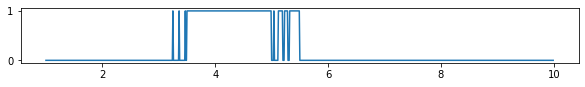

In [55]:
plt.figure(figsize=(10,1))
plt.plot(plot_data_x, plot_data_y, '-')
plt.show()

#### on Task 4: Instruct Following with Numbers with Types

In [586]:
examples = []
for i in range(100, 1000):
    examples += [{
        'a' : f"gold {str(i)[0]}.{str(i)[1]}{str(i)[2]} dollars",
        'output' : ['Yes', 'yes'] if i < 700 and i > 200 else ['No', 'no']
        # 'output' : ['No', 'no']
    }]

In [614]:
# instruction = """Please say yes only if wood costs between 3.00 and 4.99 dollars, otherwise no."""
# instruction = """Please say yes only if metal costs between 2.00 and 6.99 dollars, otherwise no."""
alpaca_prompt_template = f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
%s

### Input:
%s

### Response:
"""

In [588]:
n_correct = 0
model.eval()
pred_labels = []
with torch.no_grad():
    for example in tqdm(examples):
        inputs = example['a']
        alpaca_prompt = alpaca_prompt_template % (instruction, inputs)

        input_ids = tokenizer(alpaca_prompt, return_tensors="pt").input_ids.to("cuda")
        generated_ids = model.generate(
            input_ids, do_sample=True, 
            temperature=0.01, max_length=input_ids[0].shape[0]+3,
        )
        generated_tokens = tokenizer.decode(generated_ids[0])
        pred_label = generated_tokens.split("</s>")[0].strip(".\n").split("\n")[-1].strip()
        correct_label = example['output']
        if pred_label in correct_label:
            n_correct += 1
        print(pred_label, correct_label, inputs)
        pred_labels += [pred_label]
        

  0%|▍                                                                                                                 | 3/900 [00:00<01:26, 10.31it/s]

Yes ['No', 'no'] gold 1.00 dollars
No ['No', 'no'] gold 1.01 dollars
Yes ['No', 'no'] gold 1.02 dollars


  1%|▋                                                                                                                 | 5/900 [00:00<01:24, 10.56it/s]

Yes ['No', 'no'] gold 1.03 dollars
Yes ['No', 'no'] gold 1.04 dollars
Yes ['No', 'no'] gold 1.05 dollars


  1%|█▏                                                                                                                | 9/900 [00:00<01:23, 10.72it/s]

Yes ['No', 'no'] gold 1.06 dollars
Yes ['No', 'no'] gold 1.07 dollars
Yes ['No', 'no'] gold 1.08 dollars


  1%|█▍                                                                                                               | 11/900 [00:01<01:22, 10.76it/s]

Yes ['No', 'no'] gold 1.09 dollars
No ['No', 'no'] gold 1.10 dollars
No ['No', 'no'] gold 1.11 dollars


  2%|█▉                                                                                                               | 15/900 [00:01<01:22, 10.79it/s]

Yes ['No', 'no'] gold 1.12 dollars
No ['No', 'no'] gold 1.13 dollars
No ['No', 'no'] gold 1.14 dollars


  2%|██▏                                                                                                              | 17/900 [00:01<01:21, 10.79it/s]

Yes ['No', 'no'] gold 1.15 dollars
No ['No', 'no'] gold 1.16 dollars
No ['No', 'no'] gold 1.17 dollars


  2%|██▋                                                                                                              | 21/900 [00:01<01:21, 10.80it/s]

Yes ['No', 'no'] gold 1.18 dollars
No ['No', 'no'] gold 1.19 dollars
Yes ['No', 'no'] gold 1.20 dollars


  3%|██▉                                                                                                              | 23/900 [00:02<01:21, 10.77it/s]

No ['No', 'no'] gold 1.21 dollars
No ['No', 'no'] gold 1.22 dollars
No ['No', 'no'] gold 1.23 dollars


  3%|███▍                                                                                                             | 27/900 [00:02<01:20, 10.79it/s]

No ['No', 'no'] gold 1.24 dollars
Yes ['No', 'no'] gold 1.25 dollars
No ['No', 'no'] gold 1.26 dollars


  3%|███▋                                                                                                             | 29/900 [00:02<01:20, 10.77it/s]

Yes ['No', 'no'] gold 1.27 dollars
Yes ['No', 'no'] gold 1.28 dollars
No ['No', 'no'] gold 1.29 dollars


  4%|████▏                                                                                                            | 33/900 [00:03<01:20, 10.79it/s]

Yes ['No', 'no'] gold 1.30 dollars
No ['No', 'no'] gold 1.31 dollars
Yes ['No', 'no'] gold 1.32 dollars


  4%|████▍                                                                                                            | 35/900 [00:03<01:20, 10.80it/s]

Yes ['No', 'no'] gold 1.33 dollars
Yes ['No', 'no'] gold 1.34 dollars
Yes ['No', 'no'] gold 1.35 dollars


  4%|████▉                                                                                                            | 39/900 [00:03<01:19, 10.81it/s]

Yes ['No', 'no'] gold 1.36 dollars
Yes ['No', 'no'] gold 1.37 dollars
Yes ['No', 'no'] gold 1.38 dollars


  5%|█████▏                                                                                                           | 41/900 [00:03<01:19, 10.81it/s]

No ['No', 'no'] gold 1.39 dollars
Yes ['No', 'no'] gold 1.40 dollars
No ['No', 'no'] gold 1.41 dollars


  5%|█████▋                                                                                                           | 45/900 [00:04<01:19, 10.81it/s]

Yes ['No', 'no'] gold 1.42 dollars
Yes ['No', 'no'] gold 1.43 dollars
Yes ['No', 'no'] gold 1.44 dollars


  5%|█████▉                                                                                                           | 47/900 [00:04<01:18, 10.81it/s]

Yes ['No', 'no'] gold 1.45 dollars
Yes ['No', 'no'] gold 1.46 dollars
Yes ['No', 'no'] gold 1.47 dollars


  6%|██████▍                                                                                                          | 51/900 [00:04<01:18, 10.79it/s]

Yes ['No', 'no'] gold 1.48 dollars
Yes ['No', 'no'] gold 1.49 dollars
Yes ['No', 'no'] gold 1.50 dollars


  6%|██████▋                                                                                                          | 53/900 [00:04<01:18, 10.79it/s]

No ['No', 'no'] gold 1.51 dollars
Yes ['No', 'no'] gold 1.52 dollars
Yes ['No', 'no'] gold 1.53 dollars


  6%|███████▏                                                                                                         | 57/900 [00:05<01:18, 10.79it/s]

Yes ['No', 'no'] gold 1.54 dollars
Yes ['No', 'no'] gold 1.55 dollars
Yes ['No', 'no'] gold 1.56 dollars


  7%|███████▍                                                                                                         | 59/900 [00:05<01:17, 10.80it/s]

Yes ['No', 'no'] gold 1.57 dollars
Yes ['No', 'no'] gold 1.58 dollars
Yes ['No', 'no'] gold 1.59 dollars


  7%|███████▉                                                                                                         | 63/900 [00:05<01:17, 10.81it/s]

Yes ['No', 'no'] gold 1.60 dollars
No ['No', 'no'] gold 1.61 dollars
Yes ['No', 'no'] gold 1.62 dollars


  7%|████████▏                                                                                                        | 65/900 [00:06<01:17, 10.81it/s]

Yes ['No', 'no'] gold 1.63 dollars
Yes ['No', 'no'] gold 1.64 dollars
Yes ['No', 'no'] gold 1.65 dollars


  8%|████████▋                                                                                                        | 69/900 [00:06<01:16, 10.81it/s]

Yes ['No', 'no'] gold 1.66 dollars
Yes ['No', 'no'] gold 1.67 dollars
Yes ['No', 'no'] gold 1.68 dollars


  8%|████████▉                                                                                                        | 71/900 [00:06<01:16, 10.81it/s]

No ['No', 'no'] gold 1.69 dollars
Yes ['No', 'no'] gold 1.70 dollars
No ['No', 'no'] gold 1.71 dollars


  8%|█████████▍                                                                                                       | 75/900 [00:06<01:16, 10.79it/s]

Yes ['No', 'no'] gold 1.72 dollars
Yes ['No', 'no'] gold 1.73 dollars
Yes ['No', 'no'] gold 1.74 dollars


  9%|█████████▋                                                                                                       | 77/900 [00:07<01:16, 10.80it/s]

Yes ['No', 'no'] gold 1.75 dollars
Yes ['No', 'no'] gold 1.76 dollars
Yes ['No', 'no'] gold 1.77 dollars


  9%|██████████▏                                                                                                      | 81/900 [00:07<01:15, 10.79it/s]

Yes ['No', 'no'] gold 1.78 dollars
Yes ['No', 'no'] gold 1.79 dollars
Yes ['No', 'no'] gold 1.80 dollars


  9%|██████████▍                                                                                                      | 83/900 [00:07<01:15, 10.80it/s]

No ['No', 'no'] gold 1.81 dollars
Yes ['No', 'no'] gold 1.82 dollars
No ['No', 'no'] gold 1.83 dollars


 10%|██████████▉                                                                                                      | 87/900 [00:08<01:15, 10.79it/s]

No ['No', 'no'] gold 1.84 dollars
Yes ['No', 'no'] gold 1.85 dollars
No ['No', 'no'] gold 1.86 dollars


 10%|███████████▏                                                                                                     | 89/900 [00:08<01:15, 10.80it/s]

No ['No', 'no'] gold 1.87 dollars
Yes ['No', 'no'] gold 1.88 dollars
No ['No', 'no'] gold 1.89 dollars


 10%|███████████▋                                                                                                     | 93/900 [00:08<01:14, 10.80it/s]

No ['No', 'no'] gold 1.90 dollars
No ['No', 'no'] gold 1.91 dollars
No ['No', 'no'] gold 1.92 dollars


 11%|███████████▉                                                                                                     | 95/900 [00:08<01:14, 10.80it/s]

No ['No', 'no'] gold 1.93 dollars
No ['No', 'no'] gold 1.94 dollars
Yes ['No', 'no'] gold 1.95 dollars


 11%|████████████▍                                                                                                    | 99/900 [00:09<01:14, 10.81it/s]

Yes ['No', 'no'] gold 1.96 dollars
No ['No', 'no'] gold 1.97 dollars
Yes ['No', 'no'] gold 1.98 dollars


 11%|████████████▌                                                                                                   | 101/900 [00:09<01:13, 10.81it/s]

No ['No', 'no'] gold 1.99 dollars
Yes ['No', 'no'] gold 2.00 dollars
No ['Yes', 'yes'] gold 2.01 dollars


 12%|█████████████                                                                                                   | 105/900 [00:09<01:13, 10.81it/s]

Yes ['Yes', 'yes'] gold 2.02 dollars
Yes ['Yes', 'yes'] gold 2.03 dollars
Yes ['Yes', 'yes'] gold 2.04 dollars


 12%|█████████████▎                                                                                                  | 107/900 [00:09<01:13, 10.81it/s]

Yes ['Yes', 'yes'] gold 2.05 dollars
Yes ['Yes', 'yes'] gold 2.06 dollars
Yes ['Yes', 'yes'] gold 2.07 dollars


 12%|█████████████▊                                                                                                  | 111/900 [00:10<01:13, 10.77it/s]

Yes ['Yes', 'yes'] gold 2.08 dollars
No ['Yes', 'yes'] gold 2.09 dollars
Yes ['Yes', 'yes'] gold 2.10 dollars


 13%|██████████████                                                                                                  | 113/900 [00:10<01:12, 10.78it/s]

No ['Yes', 'yes'] gold 2.11 dollars
Yes ['Yes', 'yes'] gold 2.12 dollars
No ['Yes', 'yes'] gold 2.13 dollars


 13%|██████████████▌                                                                                                 | 117/900 [00:10<01:12, 10.78it/s]

No ['Yes', 'yes'] gold 2.14 dollars
Yes ['Yes', 'yes'] gold 2.15 dollars
No ['Yes', 'yes'] gold 2.16 dollars


 13%|██████████████▊                                                                                                 | 119/900 [00:11<01:12, 10.80it/s]

Yes ['Yes', 'yes'] gold 2.17 dollars
Yes ['Yes', 'yes'] gold 2.18 dollars
Yes ['Yes', 'yes'] gold 2.19 dollars


 14%|███████████████▎                                                                                                | 123/900 [00:11<01:11, 10.81it/s]

Yes ['Yes', 'yes'] gold 2.20 dollars
Yes ['Yes', 'yes'] gold 2.21 dollars
Yes ['Yes', 'yes'] gold 2.22 dollars


 14%|███████████████▌                                                                                                | 125/900 [00:11<01:11, 10.81it/s]

Yes ['Yes', 'yes'] gold 2.23 dollars
Yes ['Yes', 'yes'] gold 2.24 dollars
Yes ['Yes', 'yes'] gold 2.25 dollars


 14%|████████████████                                                                                                | 129/900 [00:11<01:11, 10.81it/s]

Yes ['Yes', 'yes'] gold 2.26 dollars
Yes ['Yes', 'yes'] gold 2.27 dollars
Yes ['Yes', 'yes'] gold 2.28 dollars


 15%|████████████████▎                                                                                               | 131/900 [00:12<01:11, 10.81it/s]

No ['Yes', 'yes'] gold 2.29 dollars
Yes ['Yes', 'yes'] gold 2.30 dollars
Yes ['Yes', 'yes'] gold 2.31 dollars


 15%|████████████████▊                                                                                               | 135/900 [00:12<01:10, 10.81it/s]

Yes ['Yes', 'yes'] gold 2.32 dollars
Yes ['Yes', 'yes'] gold 2.33 dollars
Yes ['Yes', 'yes'] gold 2.34 dollars


 15%|█████████████████                                                                                               | 137/900 [00:12<01:10, 10.78it/s]

Yes ['Yes', 'yes'] gold 2.35 dollars
Yes ['Yes', 'yes'] gold 2.36 dollars
Yes ['Yes', 'yes'] gold 2.37 dollars


 16%|█████████████████▌                                                                                              | 141/900 [00:13<01:10, 10.79it/s]

Yes ['Yes', 'yes'] gold 2.38 dollars
Yes ['Yes', 'yes'] gold 2.39 dollars
Yes ['Yes', 'yes'] gold 2.40 dollars


 16%|█████████████████▊                                                                                              | 143/900 [00:13<01:10, 10.80it/s]

Yes ['Yes', 'yes'] gold 2.41 dollars
Yes ['Yes', 'yes'] gold 2.42 dollars
Yes ['Yes', 'yes'] gold 2.43 dollars


 16%|██████████████████▎                                                                                             | 147/900 [00:13<01:09, 10.81it/s]

Yes ['Yes', 'yes'] gold 2.44 dollars
Yes ['Yes', 'yes'] gold 2.45 dollars
Yes ['Yes', 'yes'] gold 2.46 dollars


 17%|██████████████████▌                                                                                             | 149/900 [00:13<01:09, 10.81it/s]

Yes ['Yes', 'yes'] gold 2.47 dollars
Yes ['Yes', 'yes'] gold 2.48 dollars
Yes ['Yes', 'yes'] gold 2.49 dollars


 17%|███████████████████                                                                                             | 153/900 [00:14<01:09, 10.81it/s]

Yes ['Yes', 'yes'] gold 2.50 dollars
Yes ['Yes', 'yes'] gold 2.51 dollars
Yes ['Yes', 'yes'] gold 2.52 dollars


 17%|███████████████████▎                                                                                            | 155/900 [00:14<01:08, 10.81it/s]

Yes ['Yes', 'yes'] gold 2.53 dollars
Yes ['Yes', 'yes'] gold 2.54 dollars
Yes ['Yes', 'yes'] gold 2.55 dollars


 18%|███████████████████▊                                                                                            | 159/900 [00:14<01:08, 10.81it/s]

Yes ['Yes', 'yes'] gold 2.56 dollars
Yes ['Yes', 'yes'] gold 2.57 dollars
Yes ['Yes', 'yes'] gold 2.58 dollars


 18%|████████████████████                                                                                            | 161/900 [00:14<01:08, 10.79it/s]

Yes ['Yes', 'yes'] gold 2.59 dollars
Yes ['Yes', 'yes'] gold 2.60 dollars
No ['Yes', 'yes'] gold 2.61 dollars


 18%|████████████████████▌                                                                                           | 165/900 [00:15<01:08, 10.81it/s]

Yes ['Yes', 'yes'] gold 2.62 dollars
Yes ['Yes', 'yes'] gold 2.63 dollars
Yes ['Yes', 'yes'] gold 2.64 dollars


 19%|████████████████████▊                                                                                           | 167/900 [00:15<01:07, 10.81it/s]

Yes ['Yes', 'yes'] gold 2.65 dollars
Yes ['Yes', 'yes'] gold 2.66 dollars
Yes ['Yes', 'yes'] gold 2.67 dollars


 19%|█████████████████████▎                                                                                          | 171/900 [00:15<01:07, 10.81it/s]

Yes ['Yes', 'yes'] gold 2.68 dollars
Yes ['Yes', 'yes'] gold 2.69 dollars
Yes ['Yes', 'yes'] gold 2.70 dollars


 19%|█████████████████████▌                                                                                          | 173/900 [00:16<01:07, 10.81it/s]

Yes ['Yes', 'yes'] gold 2.71 dollars
Yes ['Yes', 'yes'] gold 2.72 dollars
Yes ['Yes', 'yes'] gold 2.73 dollars


 20%|██████████████████████                                                                                          | 177/900 [00:16<01:06, 10.82it/s]

Yes ['Yes', 'yes'] gold 2.74 dollars
Yes ['Yes', 'yes'] gold 2.75 dollars
Yes ['Yes', 'yes'] gold 2.76 dollars


 20%|██████████████████████▎                                                                                         | 179/900 [00:16<01:06, 10.79it/s]

Yes ['Yes', 'yes'] gold 2.77 dollars
Yes ['Yes', 'yes'] gold 2.78 dollars
Yes ['Yes', 'yes'] gold 2.79 dollars


 20%|██████████████████████▊                                                                                         | 183/900 [00:16<01:06, 10.76it/s]

Yes ['Yes', 'yes'] gold 2.80 dollars
Yes ['Yes', 'yes'] gold 2.81 dollars
Yes ['Yes', 'yes'] gold 2.82 dollars


 21%|███████████████████████                                                                                         | 185/900 [00:17<01:06, 10.77it/s]

Yes ['Yes', 'yes'] gold 2.83 dollars
Yes ['Yes', 'yes'] gold 2.84 dollars
Yes ['Yes', 'yes'] gold 2.85 dollars


 21%|███████████████████████▌                                                                                        | 189/900 [00:17<01:05, 10.79it/s]

Yes ['Yes', 'yes'] gold 2.86 dollars
Yes ['Yes', 'yes'] gold 2.87 dollars
Yes ['Yes', 'yes'] gold 2.88 dollars


 21%|███████████████████████▊                                                                                        | 191/900 [00:17<01:05, 10.76it/s]

Yes ['Yes', 'yes'] gold 2.89 dollars
Yes ['Yes', 'yes'] gold 2.90 dollars
No ['Yes', 'yes'] gold 2.91 dollars


 22%|████████████████████████▎                                                                                       | 195/900 [00:18<01:05, 10.76it/s]

Yes ['Yes', 'yes'] gold 2.92 dollars
Yes ['Yes', 'yes'] gold 2.93 dollars
Yes ['Yes', 'yes'] gold 2.94 dollars


 22%|████████████████████████▌                                                                                       | 197/900 [00:18<01:05, 10.78it/s]

Yes ['Yes', 'yes'] gold 2.95 dollars
Yes ['Yes', 'yes'] gold 2.96 dollars
Yes ['Yes', 'yes'] gold 2.97 dollars


 22%|█████████████████████████                                                                                       | 201/900 [00:18<01:04, 10.79it/s]

Yes ['Yes', 'yes'] gold 2.98 dollars
Yes ['Yes', 'yes'] gold 2.99 dollars
Yes ['Yes', 'yes'] gold 3.00 dollars


 23%|█████████████████████████▎                                                                                      | 203/900 [00:18<01:04, 10.80it/s]

No ['Yes', 'yes'] gold 3.01 dollars
Yes ['Yes', 'yes'] gold 3.02 dollars
Yes ['Yes', 'yes'] gold 3.03 dollars


 23%|█████████████████████████▊                                                                                      | 207/900 [00:19<01:04, 10.81it/s]

Yes ['Yes', 'yes'] gold 3.04 dollars
Yes ['Yes', 'yes'] gold 3.05 dollars
No ['Yes', 'yes'] gold 3.06 dollars


 23%|██████████████████████████                                                                                      | 209/900 [00:19<01:03, 10.81it/s]

No ['Yes', 'yes'] gold 3.07 dollars
No ['Yes', 'yes'] gold 3.08 dollars
No ['Yes', 'yes'] gold 3.09 dollars


 24%|██████████████████████████▌                                                                                     | 213/900 [00:19<01:03, 10.81it/s]

No ['Yes', 'yes'] gold 3.10 dollars
No ['Yes', 'yes'] gold 3.11 dollars
Yes ['Yes', 'yes'] gold 3.12 dollars


 24%|██████████████████████████▊                                                                                     | 215/900 [00:19<01:03, 10.82it/s]

No ['Yes', 'yes'] gold 3.13 dollars
No ['Yes', 'yes'] gold 3.14 dollars
Yes ['Yes', 'yes'] gold 3.15 dollars


 24%|███████████████████████████▎                                                                                    | 219/900 [00:20<01:03, 10.78it/s]

Yes ['Yes', 'yes'] gold 3.16 dollars
Yes ['Yes', 'yes'] gold 3.17 dollars
Yes ['Yes', 'yes'] gold 3.18 dollars


 25%|███████████████████████████▌                                                                                    | 221/900 [00:20<01:02, 10.79it/s]

No ['Yes', 'yes'] gold 3.19 dollars
Yes ['Yes', 'yes'] gold 3.20 dollars
No ['Yes', 'yes'] gold 3.21 dollars


 25%|████████████████████████████                                                                                    | 225/900 [00:20<01:02, 10.80it/s]

No ['Yes', 'yes'] gold 3.22 dollars
No ['Yes', 'yes'] gold 3.23 dollars
Yes ['Yes', 'yes'] gold 3.24 dollars


 25%|████████████████████████████▏                                                                                   | 227/900 [00:21<01:02, 10.81it/s]

Yes ['Yes', 'yes'] gold 3.25 dollars
No ['Yes', 'yes'] gold 3.26 dollars
Yes ['Yes', 'yes'] gold 3.27 dollars


 26%|████████████████████████████▋                                                                                   | 231/900 [00:21<01:01, 10.81it/s]

Yes ['Yes', 'yes'] gold 3.28 dollars
No ['Yes', 'yes'] gold 3.29 dollars
Yes ['Yes', 'yes'] gold 3.30 dollars


 26%|████████████████████████████▉                                                                                   | 233/900 [00:21<01:01, 10.81it/s]

Yes ['Yes', 'yes'] gold 3.31 dollars
Yes ['Yes', 'yes'] gold 3.32 dollars
Yes ['Yes', 'yes'] gold 3.33 dollars


 26%|█████████████████████████████▏                                                                                  | 235/900 [00:21<01:01, 10.81it/s]

Yes ['Yes', 'yes'] gold 3.34 dollars
Yes ['Yes', 'yes'] gold 3.35 dollars


 26%|█████████████████████████████▍                                                                                  | 237/900 [00:21<01:04, 10.31it/s]

Yes ['Yes', 'yes'] gold 3.36 dollars
Yes ['Yes', 'yes'] gold 3.37 dollars


 27%|█████████████████████████████▉                                                                                  | 241/900 [00:22<01:03, 10.35it/s]

Yes ['Yes', 'yes'] gold 3.38 dollars
Yes ['Yes', 'yes'] gold 3.39 dollars
Yes ['Yes', 'yes'] gold 3.40 dollars


 27%|██████████████████████████████▏                                                                                 | 243/900 [00:22<01:02, 10.49it/s]

No ['Yes', 'yes'] gold 3.41 dollars
Yes ['Yes', 'yes'] gold 3.42 dollars
Yes ['Yes', 'yes'] gold 3.43 dollars


 27%|██████████████████████████████▋                                                                                 | 247/900 [00:22<01:01, 10.65it/s]

Yes ['Yes', 'yes'] gold 3.44 dollars
Yes ['Yes', 'yes'] gold 3.45 dollars
Yes ['Yes', 'yes'] gold 3.46 dollars


 28%|██████████████████████████████▉                                                                                 | 249/900 [00:23<01:00, 10.70it/s]

Yes ['Yes', 'yes'] gold 3.47 dollars
Yes ['Yes', 'yes'] gold 3.48 dollars
Yes ['Yes', 'yes'] gold 3.49 dollars


 28%|███████████████████████████████▍                                                                                | 253/900 [00:23<01:00, 10.76it/s]

Yes ['Yes', 'yes'] gold 3.50 dollars
No ['Yes', 'yes'] gold 3.51 dollars
Yes ['Yes', 'yes'] gold 3.52 dollars


 28%|███████████████████████████████▋                                                                                | 255/900 [00:23<01:00, 10.75it/s]

Yes ['Yes', 'yes'] gold 3.53 dollars
Yes ['Yes', 'yes'] gold 3.54 dollars
Yes ['Yes', 'yes'] gold 3.55 dollars


 29%|████████████████████████████████▏                                                                               | 259/900 [00:24<00:59, 10.78it/s]

Yes ['Yes', 'yes'] gold 3.56 dollars
Yes ['Yes', 'yes'] gold 3.57 dollars
Yes ['Yes', 'yes'] gold 3.58 dollars


 29%|████████████████████████████████▍                                                                               | 261/900 [00:24<00:59, 10.79it/s]

No ['Yes', 'yes'] gold 3.59 dollars
Yes ['Yes', 'yes'] gold 3.60 dollars
No ['Yes', 'yes'] gold 3.61 dollars


 29%|████████████████████████████████▉                                                                               | 265/900 [00:24<00:58, 10.80it/s]

Yes ['Yes', 'yes'] gold 3.62 dollars
Yes ['Yes', 'yes'] gold 3.63 dollars
Yes ['Yes', 'yes'] gold 3.64 dollars


 30%|█████████████████████████████████▏                                                                              | 267/900 [00:24<00:58, 10.80it/s]

Yes ['Yes', 'yes'] gold 3.65 dollars
Yes ['Yes', 'yes'] gold 3.66 dollars
Yes ['Yes', 'yes'] gold 3.67 dollars


 30%|█████████████████████████████████▋                                                                              | 271/900 [00:25<00:58, 10.81it/s]

Yes ['Yes', 'yes'] gold 3.68 dollars
Yes ['Yes', 'yes'] gold 3.69 dollars
Yes ['Yes', 'yes'] gold 3.70 dollars


 30%|█████████████████████████████████▉                                                                              | 273/900 [00:25<00:58, 10.81it/s]

Yes ['Yes', 'yes'] gold 3.71 dollars
Yes ['Yes', 'yes'] gold 3.72 dollars
Yes ['Yes', 'yes'] gold 3.73 dollars


 31%|██████████████████████████████████▍                                                                             | 277/900 [00:25<00:57, 10.81it/s]

Yes ['Yes', 'yes'] gold 3.74 dollars
Yes ['Yes', 'yes'] gold 3.75 dollars
Yes ['Yes', 'yes'] gold 3.76 dollars


 31%|██████████████████████████████████▋                                                                             | 279/900 [00:25<00:57, 10.81it/s]

Yes ['Yes', 'yes'] gold 3.77 dollars
Yes ['Yes', 'yes'] gold 3.78 dollars
Yes ['Yes', 'yes'] gold 3.79 dollars


 31%|███████████████████████████████████▏                                                                            | 283/900 [00:26<00:57, 10.82it/s]

Yes ['Yes', 'yes'] gold 3.80 dollars
No ['Yes', 'yes'] gold 3.81 dollars
Yes ['Yes', 'yes'] gold 3.82 dollars


 32%|███████████████████████████████████▍                                                                            | 285/900 [00:26<00:56, 10.82it/s]

Yes ['Yes', 'yes'] gold 3.83 dollars
Yes ['Yes', 'yes'] gold 3.84 dollars
Yes ['Yes', 'yes'] gold 3.85 dollars


 32%|███████████████████████████████████▉                                                                            | 289/900 [00:26<00:56, 10.82it/s]

Yes ['Yes', 'yes'] gold 3.86 dollars
Yes ['Yes', 'yes'] gold 3.87 dollars
Yes ['Yes', 'yes'] gold 3.88 dollars


 32%|████████████████████████████████████▏                                                                           | 291/900 [00:27<00:56, 10.82it/s]

Yes ['Yes', 'yes'] gold 3.89 dollars
No ['Yes', 'yes'] gold 3.90 dollars
No ['Yes', 'yes'] gold 3.91 dollars


 33%|████████████████████████████████████▋                                                                           | 295/900 [00:27<00:55, 10.80it/s]

Yes ['Yes', 'yes'] gold 3.92 dollars
Yes ['Yes', 'yes'] gold 3.93 dollars
Yes ['Yes', 'yes'] gold 3.94 dollars


 33%|████████████████████████████████████▉                                                                           | 297/900 [00:27<00:55, 10.81it/s]

Yes ['Yes', 'yes'] gold 3.95 dollars
Yes ['Yes', 'yes'] gold 3.96 dollars
No ['Yes', 'yes'] gold 3.97 dollars


 33%|█████████████████████████████████████▍                                                                          | 301/900 [00:27<00:55, 10.81it/s]

No ['Yes', 'yes'] gold 3.98 dollars
Yes ['Yes', 'yes'] gold 3.99 dollars
Yes ['Yes', 'yes'] gold 4.00 dollars


 34%|█████████████████████████████████████▋                                                                          | 303/900 [00:28<00:55, 10.77it/s]

No ['Yes', 'yes'] gold 4.01 dollars
Yes ['Yes', 'yes'] gold 4.02 dollars
Yes ['Yes', 'yes'] gold 4.03 dollars


 34%|██████████████████████████████████████▏                                                                         | 307/900 [00:28<00:54, 10.80it/s]

Yes ['Yes', 'yes'] gold 4.04 dollars
Yes ['Yes', 'yes'] gold 4.05 dollars
Yes ['Yes', 'yes'] gold 4.06 dollars


 34%|██████████████████████████████████████▍                                                                         | 309/900 [00:28<00:54, 10.81it/s]

Yes ['Yes', 'yes'] gold 4.07 dollars
Yes ['Yes', 'yes'] gold 4.08 dollars
No ['Yes', 'yes'] gold 4.09 dollars


 35%|██████████████████████████████████████▉                                                                         | 313/900 [00:29<00:54, 10.81it/s]

No ['Yes', 'yes'] gold 4.10 dollars
No ['Yes', 'yes'] gold 4.11 dollars
Yes ['Yes', 'yes'] gold 4.12 dollars


 35%|███████████████████████████████████████▏                                                                        | 315/900 [00:29<00:54, 10.82it/s]

Yes ['Yes', 'yes'] gold 4.13 dollars
Yes ['Yes', 'yes'] gold 4.14 dollars
Yes ['Yes', 'yes'] gold 4.15 dollars


 35%|███████████████████████████████████████▋                                                                        | 319/900 [00:29<00:53, 10.82it/s]

Yes ['Yes', 'yes'] gold 4.16 dollars
Yes ['Yes', 'yes'] gold 4.17 dollars
Yes ['Yes', 'yes'] gold 4.18 dollars


 36%|███████████████████████████████████████▉                                                                        | 321/900 [00:29<00:53, 10.81it/s]

Yes ['Yes', 'yes'] gold 4.19 dollars
Yes ['Yes', 'yes'] gold 4.20 dollars
Yes ['Yes', 'yes'] gold 4.21 dollars


 36%|████████████████████████████████████████▍                                                                       | 325/900 [00:30<00:53, 10.81it/s]

Yes ['Yes', 'yes'] gold 4.22 dollars
Yes ['Yes', 'yes'] gold 4.23 dollars
Yes ['Yes', 'yes'] gold 4.24 dollars


 36%|████████████████████████████████████████▋                                                                       | 327/900 [00:30<00:52, 10.82it/s]

Yes ['Yes', 'yes'] gold 4.25 dollars
Yes ['Yes', 'yes'] gold 4.26 dollars
Yes ['Yes', 'yes'] gold 4.27 dollars


 37%|█████████████████████████████████████████▏                                                                      | 331/900 [00:30<00:52, 10.82it/s]

Yes ['Yes', 'yes'] gold 4.28 dollars
Yes ['Yes', 'yes'] gold 4.29 dollars
Yes ['Yes', 'yes'] gold 4.30 dollars


 37%|█████████████████████████████████████████▍                                                                      | 333/900 [00:30<00:52, 10.82it/s]

Yes ['Yes', 'yes'] gold 4.31 dollars
Yes ['Yes', 'yes'] gold 4.32 dollars
Yes ['Yes', 'yes'] gold 4.33 dollars


 37%|█████████████████████████████████████████▉                                                                      | 337/900 [00:31<00:52, 10.77it/s]

Yes ['Yes', 'yes'] gold 4.34 dollars
Yes ['Yes', 'yes'] gold 4.35 dollars
Yes ['Yes', 'yes'] gold 4.36 dollars


 38%|██████████████████████████████████████████▏                                                                     | 339/900 [00:31<00:51, 10.79it/s]

Yes ['Yes', 'yes'] gold 4.37 dollars
Yes ['Yes', 'yes'] gold 4.38 dollars
Yes ['Yes', 'yes'] gold 4.39 dollars


 38%|██████████████████████████████████████████▋                                                                     | 343/900 [00:31<00:51, 10.81it/s]

Yes ['Yes', 'yes'] gold 4.40 dollars
Yes ['Yes', 'yes'] gold 4.41 dollars
Yes ['Yes', 'yes'] gold 4.42 dollars


 38%|██████████████████████████████████████████▉                                                                     | 345/900 [00:32<00:51, 10.81it/s]

Yes ['Yes', 'yes'] gold 4.43 dollars
Yes ['Yes', 'yes'] gold 4.44 dollars
Yes ['Yes', 'yes'] gold 4.45 dollars


 39%|███████████████████████████████████████████▍                                                                    | 349/900 [00:32<00:50, 10.81it/s]

Yes ['Yes', 'yes'] gold 4.46 dollars
Yes ['Yes', 'yes'] gold 4.47 dollars
Yes ['Yes', 'yes'] gold 4.48 dollars


 39%|███████████████████████████████████████████▋                                                                    | 351/900 [00:32<00:50, 10.82it/s]

Yes ['Yes', 'yes'] gold 4.49 dollars
Yes ['Yes', 'yes'] gold 4.50 dollars
Yes ['Yes', 'yes'] gold 4.51 dollars


 39%|████████████████████████████████████████████▏                                                                   | 355/900 [00:32<00:50, 10.82it/s]

Yes ['Yes', 'yes'] gold 4.52 dollars
Yes ['Yes', 'yes'] gold 4.53 dollars
Yes ['Yes', 'yes'] gold 4.54 dollars


 40%|████████████████████████████████████████████▍                                                                   | 357/900 [00:33<00:50, 10.82it/s]

Yes ['Yes', 'yes'] gold 4.55 dollars
Yes ['Yes', 'yes'] gold 4.56 dollars
Yes ['Yes', 'yes'] gold 4.57 dollars


 40%|████████████████████████████████████████████▉                                                                   | 361/900 [00:33<00:49, 10.82it/s]

Yes ['Yes', 'yes'] gold 4.58 dollars
Yes ['Yes', 'yes'] gold 4.59 dollars
Yes ['Yes', 'yes'] gold 4.60 dollars


 40%|█████████████████████████████████████████████▏                                                                  | 363/900 [00:33<00:49, 10.82it/s]

Yes ['Yes', 'yes'] gold 4.61 dollars
Yes ['Yes', 'yes'] gold 4.62 dollars
Yes ['Yes', 'yes'] gold 4.63 dollars


 41%|█████████████████████████████████████████████▋                                                                  | 367/900 [00:34<00:49, 10.79it/s]

Yes ['Yes', 'yes'] gold 4.64 dollars
Yes ['Yes', 'yes'] gold 4.65 dollars
Yes ['Yes', 'yes'] gold 4.66 dollars


 41%|█████████████████████████████████████████████▉                                                                  | 369/900 [00:34<00:49, 10.79it/s]

Yes ['Yes', 'yes'] gold 4.67 dollars
Yes ['Yes', 'yes'] gold 4.68 dollars
Yes ['Yes', 'yes'] gold 4.69 dollars


 41%|██████████████████████████████████████████████▍                                                                 | 373/900 [00:34<00:48, 10.81it/s]

Yes ['Yes', 'yes'] gold 4.70 dollars
Yes ['Yes', 'yes'] gold 4.71 dollars
Yes ['Yes', 'yes'] gold 4.72 dollars


 42%|██████████████████████████████████████████████▋                                                                 | 375/900 [00:34<00:48, 10.81it/s]

Yes ['Yes', 'yes'] gold 4.73 dollars
Yes ['Yes', 'yes'] gold 4.74 dollars
Yes ['Yes', 'yes'] gold 4.75 dollars


 42%|███████████████████████████████████████████████▏                                                                | 379/900 [00:35<00:48, 10.77it/s]

Yes ['Yes', 'yes'] gold 4.76 dollars
Yes ['Yes', 'yes'] gold 4.77 dollars
Yes ['Yes', 'yes'] gold 4.78 dollars


 42%|███████████████████████████████████████████████▍                                                                | 381/900 [00:35<00:48, 10.78it/s]

Yes ['Yes', 'yes'] gold 4.79 dollars
Yes ['Yes', 'yes'] gold 4.80 dollars
Yes ['Yes', 'yes'] gold 4.81 dollars


 43%|███████████████████████████████████████████████▉                                                                | 385/900 [00:35<00:47, 10.80it/s]

Yes ['Yes', 'yes'] gold 4.82 dollars
Yes ['Yes', 'yes'] gold 4.83 dollars
Yes ['Yes', 'yes'] gold 4.84 dollars


 43%|████████████████████████████████████████████████▏                                                               | 387/900 [00:35<00:47, 10.77it/s]

Yes ['Yes', 'yes'] gold 4.85 dollars
Yes ['Yes', 'yes'] gold 4.86 dollars
Yes ['Yes', 'yes'] gold 4.87 dollars


 43%|████████████████████████████████████████████████▋                                                               | 391/900 [00:36<00:47, 10.80it/s]

Yes ['Yes', 'yes'] gold 4.88 dollars
Yes ['Yes', 'yes'] gold 4.89 dollars
Yes ['Yes', 'yes'] gold 4.90 dollars


 44%|████████████████████████████████████████████████▉                                                               | 393/900 [00:36<00:46, 10.80it/s]

No ['Yes', 'yes'] gold 4.91 dollars
Yes ['Yes', 'yes'] gold 4.92 dollars
Yes ['Yes', 'yes'] gold 4.93 dollars


 44%|█████████████████████████████████████████████████▍                                                              | 397/900 [00:36<00:46, 10.80it/s]

Yes ['Yes', 'yes'] gold 4.94 dollars
Yes ['Yes', 'yes'] gold 4.95 dollars
Yes ['Yes', 'yes'] gold 4.96 dollars


 44%|█████████████████████████████████████████████████▋                                                              | 399/900 [00:37<00:46, 10.81it/s]

Yes ['Yes', 'yes'] gold 4.97 dollars
Yes ['Yes', 'yes'] gold 4.98 dollars
Yes ['Yes', 'yes'] gold 4.99 dollars


 45%|██████████████████████████████████████████████████▏                                                             | 403/900 [00:37<00:45, 10.81it/s]

Yes ['Yes', 'yes'] gold 5.00 dollars
No ['Yes', 'yes'] gold 5.01 dollars
Yes ['Yes', 'yes'] gold 5.02 dollars


 45%|██████████████████████████████████████████████████▍                                                             | 405/900 [00:37<00:45, 10.81it/s]

Yes ['Yes', 'yes'] gold 5.03 dollars
Yes ['Yes', 'yes'] gold 5.04 dollars
Yes ['Yes', 'yes'] gold 5.05 dollars


 45%|██████████████████████████████████████████████████▉                                                             | 409/900 [00:37<00:45, 10.80it/s]

Yes ['Yes', 'yes'] gold 5.06 dollars
Yes ['Yes', 'yes'] gold 5.07 dollars
Yes ['Yes', 'yes'] gold 5.08 dollars


 46%|███████████████████████████████████████████████████▏                                                            | 411/900 [00:38<00:45, 10.78it/s]

No ['Yes', 'yes'] gold 5.09 dollars
No ['Yes', 'yes'] gold 5.10 dollars
No ['Yes', 'yes'] gold 5.11 dollars


 46%|███████████████████████████████████████████████████▋                                                            | 415/900 [00:38<00:44, 10.78it/s]

Yes ['Yes', 'yes'] gold 5.12 dollars
Yes ['Yes', 'yes'] gold 5.13 dollars
Yes ['Yes', 'yes'] gold 5.14 dollars


 46%|███████████████████████████████████████████████████▉                                                            | 417/900 [00:38<00:44, 10.79it/s]

Yes ['Yes', 'yes'] gold 5.15 dollars
Yes ['Yes', 'yes'] gold 5.16 dollars
Yes ['Yes', 'yes'] gold 5.17 dollars


 47%|████████████████████████████████████████████████████▍                                                           | 421/900 [00:39<00:44, 10.78it/s]

Yes ['Yes', 'yes'] gold 5.18 dollars
Yes ['Yes', 'yes'] gold 5.19 dollars
Yes ['Yes', 'yes'] gold 5.20 dollars


 47%|████████████████████████████████████████████████████▋                                                           | 423/900 [00:39<00:44, 10.78it/s]

Yes ['Yes', 'yes'] gold 5.21 dollars
Yes ['Yes', 'yes'] gold 5.22 dollars
Yes ['Yes', 'yes'] gold 5.23 dollars


 47%|█████████████████████████████████████████████████████▏                                                          | 427/900 [00:39<00:43, 10.77it/s]

Yes ['Yes', 'yes'] gold 5.24 dollars
Yes ['Yes', 'yes'] gold 5.25 dollars
Yes ['Yes', 'yes'] gold 5.26 dollars


 48%|█████████████████████████████████████████████████████▍                                                          | 429/900 [00:39<00:43, 10.79it/s]

Yes ['Yes', 'yes'] gold 5.27 dollars
Yes ['Yes', 'yes'] gold 5.28 dollars
Yes ['Yes', 'yes'] gold 5.29 dollars


 48%|█████████████████████████████████████████████████████▉                                                          | 433/900 [00:40<00:43, 10.81it/s]

Yes ['Yes', 'yes'] gold 5.30 dollars
Yes ['Yes', 'yes'] gold 5.31 dollars
Yes ['Yes', 'yes'] gold 5.32 dollars


 48%|██████████████████████████████████████████████████████▏                                                         | 435/900 [00:40<00:43, 10.81it/s]

Yes ['Yes', 'yes'] gold 5.33 dollars
Yes ['Yes', 'yes'] gold 5.34 dollars
Yes ['Yes', 'yes'] gold 5.35 dollars


 49%|██████████████████████████████████████████████████████▋                                                         | 439/900 [00:40<00:42, 10.80it/s]

Yes ['Yes', 'yes'] gold 5.36 dollars
Yes ['Yes', 'yes'] gold 5.37 dollars
Yes ['Yes', 'yes'] gold 5.38 dollars


 49%|██████████████████████████████████████████████████████▉                                                         | 441/900 [00:40<00:42, 10.81it/s]

Yes ['Yes', 'yes'] gold 5.39 dollars
Yes ['Yes', 'yes'] gold 5.40 dollars
Yes ['Yes', 'yes'] gold 5.41 dollars


 49%|███████████████████████████████████████████████████████▍                                                        | 445/900 [00:41<00:42, 10.79it/s]

Yes ['Yes', 'yes'] gold 5.42 dollars
Yes ['Yes', 'yes'] gold 5.43 dollars
Yes ['Yes', 'yes'] gold 5.44 dollars


 50%|███████████████████████████████████████████████████████▋                                                        | 447/900 [00:41<00:42, 10.77it/s]

Yes ['Yes', 'yes'] gold 5.45 dollars
Yes ['Yes', 'yes'] gold 5.46 dollars
Yes ['Yes', 'yes'] gold 5.47 dollars


 50%|████████████████████████████████████████████████████████                                                        | 451/900 [00:41<00:41, 10.79it/s]

Yes ['Yes', 'yes'] gold 5.48 dollars
Yes ['Yes', 'yes'] gold 5.49 dollars
Yes ['Yes', 'yes'] gold 5.50 dollars


 50%|████████████████████████████████████████████████████████▎                                                       | 453/900 [00:42<00:41, 10.80it/s]

Yes ['Yes', 'yes'] gold 5.51 dollars
Yes ['Yes', 'yes'] gold 5.52 dollars
Yes ['Yes', 'yes'] gold 5.53 dollars


 51%|████████████████████████████████████████████████████████▊                                                       | 457/900 [00:42<00:40, 10.82it/s]

Yes ['Yes', 'yes'] gold 5.54 dollars
Yes ['Yes', 'yes'] gold 5.55 dollars
Yes ['Yes', 'yes'] gold 5.56 dollars


 51%|█████████████████████████████████████████████████████████                                                       | 459/900 [00:42<00:40, 10.82it/s]

Yes ['Yes', 'yes'] gold 5.57 dollars
Yes ['Yes', 'yes'] gold 5.58 dollars
Yes ['Yes', 'yes'] gold 5.59 dollars


 51%|█████████████████████████████████████████████████████████▌                                                      | 463/900 [00:42<00:40, 10.82it/s]

Yes ['Yes', 'yes'] gold 5.60 dollars
Yes ['Yes', 'yes'] gold 5.61 dollars
Yes ['Yes', 'yes'] gold 5.62 dollars


 52%|█████████████████████████████████████████████████████████▊                                                      | 465/900 [00:43<00:40, 10.82it/s]

Yes ['Yes', 'yes'] gold 5.63 dollars
Yes ['Yes', 'yes'] gold 5.64 dollars
Yes ['Yes', 'yes'] gold 5.65 dollars


 52%|██████████████████████████████████████████████████████████▎                                                     | 469/900 [00:43<00:39, 10.83it/s]

Yes ['Yes', 'yes'] gold 5.66 dollars
Yes ['Yes', 'yes'] gold 5.67 dollars
Yes ['Yes', 'yes'] gold 5.68 dollars


 52%|██████████████████████████████████████████████████████████▌                                                     | 471/900 [00:43<00:39, 10.83it/s]

Yes ['Yes', 'yes'] gold 5.69 dollars
Yes ['Yes', 'yes'] gold 5.70 dollars
Yes ['Yes', 'yes'] gold 5.71 dollars


 53%|███████████████████████████████████████████████████████████                                                     | 475/900 [00:44<00:39, 10.82it/s]

Yes ['Yes', 'yes'] gold 5.72 dollars
Yes ['Yes', 'yes'] gold 5.73 dollars
Yes ['Yes', 'yes'] gold 5.74 dollars


 53%|███████████████████████████████████████████████████████████▎                                                    | 477/900 [00:44<00:39, 10.81it/s]

Yes ['Yes', 'yes'] gold 5.75 dollars
Yes ['Yes', 'yes'] gold 5.76 dollars
Yes ['Yes', 'yes'] gold 5.77 dollars


 53%|███████████████████████████████████████████████████████████▊                                                    | 481/900 [00:44<00:38, 10.79it/s]

Yes ['Yes', 'yes'] gold 5.78 dollars
Yes ['Yes', 'yes'] gold 5.79 dollars
Yes ['Yes', 'yes'] gold 5.80 dollars


 54%|████████████████████████████████████████████████████████████                                                    | 483/900 [00:44<00:38, 10.79it/s]

Yes ['Yes', 'yes'] gold 5.81 dollars
Yes ['Yes', 'yes'] gold 5.82 dollars
Yes ['Yes', 'yes'] gold 5.83 dollars


 54%|████████████████████████████████████████████████████████████▌                                                   | 487/900 [00:45<00:38, 10.80it/s]

Yes ['Yes', 'yes'] gold 5.84 dollars
Yes ['Yes', 'yes'] gold 5.85 dollars
Yes ['Yes', 'yes'] gold 5.86 dollars


 54%|████████████████████████████████████████████████████████████▊                                                   | 489/900 [00:45<00:38, 10.81it/s]

Yes ['Yes', 'yes'] gold 5.87 dollars
Yes ['Yes', 'yes'] gold 5.88 dollars
Yes ['Yes', 'yes'] gold 5.89 dollars


 55%|█████████████████████████████████████████████████████████████▎                                                  | 493/900 [00:45<00:37, 10.80it/s]

Yes ['Yes', 'yes'] gold 5.90 dollars
No ['Yes', 'yes'] gold 5.91 dollars
Yes ['Yes', 'yes'] gold 5.92 dollars


 55%|█████████████████████████████████████████████████████████████▌                                                  | 495/900 [00:45<00:37, 10.81it/s]

Yes ['Yes', 'yes'] gold 5.93 dollars
Yes ['Yes', 'yes'] gold 5.94 dollars
Yes ['Yes', 'yes'] gold 5.95 dollars


 55%|██████████████████████████████████████████████████████████████                                                  | 499/900 [00:46<00:37, 10.81it/s]

Yes ['Yes', 'yes'] gold 5.96 dollars
Yes ['Yes', 'yes'] gold 5.97 dollars
Yes ['Yes', 'yes'] gold 5.98 dollars


 56%|██████████████████████████████████████████████████████████████▎                                                 | 501/900 [00:46<00:36, 10.81it/s]

Yes ['Yes', 'yes'] gold 5.99 dollars
Yes ['Yes', 'yes'] gold 6.00 dollars
No ['Yes', 'yes'] gold 6.01 dollars


 56%|██████████████████████████████████████████████████████████████▊                                                 | 505/900 [00:46<00:36, 10.81it/s]

Yes ['Yes', 'yes'] gold 6.02 dollars
Yes ['Yes', 'yes'] gold 6.03 dollars
Yes ['Yes', 'yes'] gold 6.04 dollars


 56%|███████████████████████████████████████████████████████████████                                                 | 507/900 [00:46<00:36, 10.82it/s]

Yes ['Yes', 'yes'] gold 6.05 dollars
Yes ['Yes', 'yes'] gold 6.06 dollars
Yes ['Yes', 'yes'] gold 6.07 dollars


 57%|███████████████████████████████████████████████████████████████▌                                                | 511/900 [00:47<00:35, 10.81it/s]

Yes ['Yes', 'yes'] gold 6.08 dollars
Yes ['Yes', 'yes'] gold 6.09 dollars
Yes ['Yes', 'yes'] gold 6.10 dollars


 57%|███████████████████████████████████████████████████████████████▊                                                | 513/900 [00:47<00:35, 10.81it/s]

Yes ['Yes', 'yes'] gold 6.11 dollars
Yes ['Yes', 'yes'] gold 6.12 dollars
Yes ['Yes', 'yes'] gold 6.13 dollars


 57%|████████████████████████████████████████████████████████████████▎                                               | 517/900 [00:47<00:35, 10.79it/s]

Yes ['Yes', 'yes'] gold 6.14 dollars
Yes ['Yes', 'yes'] gold 6.15 dollars
Yes ['Yes', 'yes'] gold 6.16 dollars


 58%|████████████████████████████████████████████████████████████████▌                                               | 519/900 [00:48<00:35, 10.80it/s]

Yes ['Yes', 'yes'] gold 6.17 dollars
Yes ['Yes', 'yes'] gold 6.18 dollars
Yes ['Yes', 'yes'] gold 6.19 dollars


 58%|█████████████████████████████████████████████████████████████████                                               | 523/900 [00:48<00:34, 10.80it/s]

Yes ['Yes', 'yes'] gold 6.20 dollars
Yes ['Yes', 'yes'] gold 6.21 dollars
Yes ['Yes', 'yes'] gold 6.22 dollars


 58%|█████████████████████████████████████████████████████████████████▎                                              | 525/900 [00:48<00:34, 10.80it/s]

Yes ['Yes', 'yes'] gold 6.23 dollars
Yes ['Yes', 'yes'] gold 6.24 dollars
Yes ['Yes', 'yes'] gold 6.25 dollars


 59%|█████████████████████████████████████████████████████████████████▊                                              | 529/900 [00:49<00:34, 10.81it/s]

Yes ['Yes', 'yes'] gold 6.26 dollars
Yes ['Yes', 'yes'] gold 6.27 dollars
Yes ['Yes', 'yes'] gold 6.28 dollars


 59%|██████████████████████████████████████████████████████████████████                                              | 531/900 [00:49<00:34, 10.81it/s]

Yes ['Yes', 'yes'] gold 6.29 dollars
Yes ['Yes', 'yes'] gold 6.30 dollars
Yes ['Yes', 'yes'] gold 6.31 dollars


 59%|██████████████████████████████████████████████████████████████████▌                                             | 535/900 [00:49<00:33, 10.82it/s]

Yes ['Yes', 'yes'] gold 6.32 dollars
Yes ['Yes', 'yes'] gold 6.33 dollars
Yes ['Yes', 'yes'] gold 6.34 dollars


 60%|██████████████████████████████████████████████████████████████████▊                                             | 537/900 [00:49<00:33, 10.81it/s]

Yes ['Yes', 'yes'] gold 6.35 dollars
Yes ['Yes', 'yes'] gold 6.36 dollars
Yes ['Yes', 'yes'] gold 6.37 dollars


 60%|███████████████████████████████████████████████████████████████████▎                                            | 541/900 [00:50<00:33, 10.82it/s]

Yes ['Yes', 'yes'] gold 6.38 dollars
Yes ['Yes', 'yes'] gold 6.39 dollars
Yes ['Yes', 'yes'] gold 6.40 dollars


 60%|███████████████████████████████████████████████████████████████████▌                                            | 543/900 [00:50<00:33, 10.78it/s]

Yes ['Yes', 'yes'] gold 6.41 dollars
Yes ['Yes', 'yes'] gold 6.42 dollars
Yes ['Yes', 'yes'] gold 6.43 dollars


 61%|████████████████████████████████████████████████████████████████████                                            | 547/900 [00:50<00:32, 10.78it/s]

Yes ['Yes', 'yes'] gold 6.44 dollars
Yes ['Yes', 'yes'] gold 6.45 dollars
Yes ['Yes', 'yes'] gold 6.46 dollars


 61%|████████████████████████████████████████████████████████████████████▎                                           | 549/900 [00:50<00:32, 10.79it/s]

Yes ['Yes', 'yes'] gold 6.47 dollars
Yes ['Yes', 'yes'] gold 6.48 dollars
Yes ['Yes', 'yes'] gold 6.49 dollars


 61%|████████████████████████████████████████████████████████████████████▊                                           | 553/900 [00:51<00:32, 10.80it/s]

Yes ['Yes', 'yes'] gold 6.50 dollars
Yes ['Yes', 'yes'] gold 6.51 dollars
Yes ['Yes', 'yes'] gold 6.52 dollars


 62%|█████████████████████████████████████████████████████████████████████                                           | 555/900 [00:51<00:31, 10.81it/s]

Yes ['Yes', 'yes'] gold 6.53 dollars
Yes ['Yes', 'yes'] gold 6.54 dollars
Yes ['Yes', 'yes'] gold 6.55 dollars


 62%|█████████████████████████████████████████████████████████████████████▌                                          | 559/900 [00:51<00:31, 10.74it/s]

Yes ['Yes', 'yes'] gold 6.56 dollars
Yes ['Yes', 'yes'] gold 6.57 dollars
Yes ['Yes', 'yes'] gold 6.58 dollars


 62%|█████████████████████████████████████████████████████████████████████▊                                          | 561/900 [00:52<00:32, 10.31it/s]

Yes ['Yes', 'yes'] gold 6.59 dollars
Yes ['Yes', 'yes'] gold 6.60 dollars


 63%|██████████████████████████████████████████████████████████████████████                                          | 563/900 [00:52<00:33, 10.20it/s]

Yes ['Yes', 'yes'] gold 6.61 dollars
Yes ['Yes', 'yes'] gold 6.62 dollars
Yes ['Yes', 'yes'] gold 6.63 dollars


 63%|██████████████████████████████████████████████████████████████████████▌                                         | 567/900 [00:52<00:31, 10.51it/s]

Yes ['Yes', 'yes'] gold 6.64 dollars
Yes ['Yes', 'yes'] gold 6.65 dollars
Yes ['Yes', 'yes'] gold 6.66 dollars


 63%|██████████████████████████████████████████████████████████████████████▊                                         | 569/900 [00:52<00:31, 10.58it/s]

Yes ['Yes', 'yes'] gold 6.67 dollars
Yes ['Yes', 'yes'] gold 6.68 dollars
Yes ['Yes', 'yes'] gold 6.69 dollars


 64%|███████████████████████████████████████████████████████████████████████▎                                        | 573/900 [00:53<00:30, 10.70it/s]

Yes ['Yes', 'yes'] gold 6.70 dollars
Yes ['Yes', 'yes'] gold 6.71 dollars
Yes ['Yes', 'yes'] gold 6.72 dollars


 64%|███████████████████████████████████████████████████████████████████████▌                                        | 575/900 [00:53<00:30, 10.74it/s]

Yes ['Yes', 'yes'] gold 6.73 dollars
Yes ['Yes', 'yes'] gold 6.74 dollars
Yes ['Yes', 'yes'] gold 6.75 dollars


 64%|████████████████████████████████████████████████████████████████████████                                        | 579/900 [00:53<00:29, 10.78it/s]

Yes ['Yes', 'yes'] gold 6.76 dollars
Yes ['Yes', 'yes'] gold 6.77 dollars
Yes ['Yes', 'yes'] gold 6.78 dollars


 65%|████████████████████████████████████████████████████████████████████████▎                                       | 581/900 [00:53<00:29, 10.78it/s]

Yes ['Yes', 'yes'] gold 6.79 dollars
Yes ['Yes', 'yes'] gold 6.80 dollars
Yes ['Yes', 'yes'] gold 6.81 dollars


 65%|████████████████████████████████████████████████████████████████████████▊                                       | 585/900 [00:54<00:29, 10.80it/s]

Yes ['Yes', 'yes'] gold 6.82 dollars
Yes ['Yes', 'yes'] gold 6.83 dollars
Yes ['Yes', 'yes'] gold 6.84 dollars


 65%|█████████████████████████████████████████████████████████████████████████                                       | 587/900 [00:54<00:28, 10.80it/s]

Yes ['Yes', 'yes'] gold 6.85 dollars
Yes ['Yes', 'yes'] gold 6.86 dollars
Yes ['Yes', 'yes'] gold 6.87 dollars


 66%|█████████████████████████████████████████████████████████████████████████▌                                      | 591/900 [00:54<00:28, 10.81it/s]

Yes ['Yes', 'yes'] gold 6.88 dollars
Yes ['Yes', 'yes'] gold 6.89 dollars
Yes ['Yes', 'yes'] gold 6.90 dollars


 66%|█████████████████████████████████████████████████████████████████████████▊                                      | 593/900 [00:55<00:28, 10.81it/s]

Yes ['Yes', 'yes'] gold 6.91 dollars
Yes ['Yes', 'yes'] gold 6.92 dollars
Yes ['Yes', 'yes'] gold 6.93 dollars


 66%|██████████████████████████████████████████████████████████████████████████▎                                     | 597/900 [00:55<00:28, 10.82it/s]

Yes ['Yes', 'yes'] gold 6.94 dollars
Yes ['Yes', 'yes'] gold 6.95 dollars
Yes ['Yes', 'yes'] gold 6.96 dollars


 67%|██████████████████████████████████████████████████████████████████████████▌                                     | 599/900 [00:55<00:27, 10.75it/s]

Yes ['Yes', 'yes'] gold 6.97 dollars
Yes ['Yes', 'yes'] gold 6.98 dollars
Yes ['Yes', 'yes'] gold 6.99 dollars


 67%|███████████████████████████████████████████████████████████████████████████                                     | 603/900 [00:55<00:27, 10.78it/s]

No ['No', 'no'] gold 7.00 dollars
No ['No', 'no'] gold 7.01 dollars
No ['No', 'no'] gold 7.02 dollars


 67%|███████████████████████████████████████████████████████████████████████████▎                                    | 605/900 [00:56<00:27, 10.79it/s]

No ['No', 'no'] gold 7.03 dollars
No ['No', 'no'] gold 7.04 dollars
No ['No', 'no'] gold 7.05 dollars


 68%|███████████████████████████████████████████████████████████████████████████▊                                    | 609/900 [00:56<00:26, 10.80it/s]

No ['No', 'no'] gold 7.06 dollars
No ['No', 'no'] gold 7.07 dollars
No ['No', 'no'] gold 7.08 dollars


 68%|████████████████████████████████████████████████████████████████████████████                                    | 611/900 [00:56<00:26, 10.81it/s]

No ['No', 'no'] gold 7.09 dollars
No ['No', 'no'] gold 7.10 dollars
No ['No', 'no'] gold 7.11 dollars


 68%|████████████████████████████████████████████████████████████████████████████▌                                   | 615/900 [00:57<00:26, 10.82it/s]

No ['No', 'no'] gold 7.12 dollars
No ['No', 'no'] gold 7.13 dollars
No ['No', 'no'] gold 7.14 dollars


 69%|████████████████████████████████████████████████████████████████████████████▊                                   | 617/900 [00:57<00:26, 10.81it/s]

No ['No', 'no'] gold 7.15 dollars
No ['No', 'no'] gold 7.16 dollars
No ['No', 'no'] gold 7.17 dollars


 69%|█████████████████████████████████████████████████████████████████████████████▎                                  | 621/900 [00:57<00:25, 10.82it/s]

No ['No', 'no'] gold 7.18 dollars
No ['No', 'no'] gold 7.19 dollars
No ['No', 'no'] gold 7.20 dollars


 69%|█████████████████████████████████████████████████████████████████████████████▌                                  | 623/900 [00:57<00:25, 10.79it/s]

No ['No', 'no'] gold 7.21 dollars
No ['No', 'no'] gold 7.22 dollars
No ['No', 'no'] gold 7.23 dollars


 70%|██████████████████████████████████████████████████████████████████████████████                                  | 627/900 [00:58<00:25, 10.80it/s]

No ['No', 'no'] gold 7.24 dollars
No ['No', 'no'] gold 7.25 dollars
No ['No', 'no'] gold 7.26 dollars


 70%|██████████████████████████████████████████████████████████████████████████████▎                                 | 629/900 [00:58<00:25, 10.80it/s]

No ['No', 'no'] gold 7.27 dollars
No ['No', 'no'] gold 7.28 dollars
No ['No', 'no'] gold 7.29 dollars


 70%|██████████████████████████████████████████████████████████████████████████████▊                                 | 633/900 [00:58<00:24, 10.81it/s]

No ['No', 'no'] gold 7.30 dollars
No ['No', 'no'] gold 7.31 dollars
No ['No', 'no'] gold 7.32 dollars


 71%|███████████████████████████████████████████████████████████████████████████████                                 | 635/900 [00:58<00:24, 10.81it/s]

No ['No', 'no'] gold 7.33 dollars
No ['No', 'no'] gold 7.34 dollars
Yes ['No', 'no'] gold 7.35 dollars


 71%|███████████████████████████████████████████████████████████████████████████████▌                                | 639/900 [00:59<00:24, 10.82it/s]

No ['No', 'no'] gold 7.36 dollars
No ['No', 'no'] gold 7.37 dollars
No ['No', 'no'] gold 7.38 dollars


 71%|███████████████████████████████████████████████████████████████████████████████▊                                | 641/900 [00:59<00:23, 10.82it/s]

No ['No', 'no'] gold 7.39 dollars
No ['No', 'no'] gold 7.40 dollars
No ['No', 'no'] gold 7.41 dollars


 72%|████████████████████████████████████████████████████████████████████████████████▎                               | 645/900 [00:59<00:23, 10.80it/s]

No ['No', 'no'] gold 7.42 dollars
No ['No', 'no'] gold 7.43 dollars
No ['No', 'no'] gold 7.44 dollars


 72%|████████████████████████████████████████████████████████████████████████████████▌                               | 647/900 [01:00<00:23, 10.80it/s]

No ['No', 'no'] gold 7.45 dollars
No ['No', 'no'] gold 7.46 dollars
No ['No', 'no'] gold 7.47 dollars


 72%|█████████████████████████████████████████████████████████████████████████████████                               | 651/900 [01:00<00:23, 10.81it/s]

No ['No', 'no'] gold 7.48 dollars
No ['No', 'no'] gold 7.49 dollars
No ['No', 'no'] gold 7.50 dollars


 73%|█████████████████████████████████████████████████████████████████████████████████▎                              | 653/900 [01:00<00:22, 10.82it/s]

No ['No', 'no'] gold 7.51 dollars
Yes ['No', 'no'] gold 7.52 dollars
No ['No', 'no'] gold 7.53 dollars


 73%|█████████████████████████████████████████████████████████████████████████████████▊                              | 657/900 [01:00<00:22, 10.82it/s]

No ['No', 'no'] gold 7.54 dollars
No ['No', 'no'] gold 7.55 dollars
No ['No', 'no'] gold 7.56 dollars


 73%|██████████████████████████████████████████████████████████████████████████████████                              | 659/900 [01:01<00:22, 10.82it/s]

No ['No', 'no'] gold 7.57 dollars
No ['No', 'no'] gold 7.58 dollars
No ['No', 'no'] gold 7.59 dollars


 74%|██████████████████████████████████████████████████████████████████████████████████▌                             | 663/900 [01:01<00:21, 10.82it/s]

No ['No', 'no'] gold 7.60 dollars
No ['No', 'no'] gold 7.61 dollars
No ['No', 'no'] gold 7.62 dollars


 74%|██████████████████████████████████████████████████████████████████████████████████▊                             | 665/900 [01:01<00:21, 10.82it/s]

No ['No', 'no'] gold 7.63 dollars
No ['No', 'no'] gold 7.64 dollars
No ['No', 'no'] gold 7.65 dollars


 74%|███████████████████████████████████████████████████████████████████████████████████▎                            | 669/900 [01:02<00:21, 10.82it/s]

No ['No', 'no'] gold 7.66 dollars
No ['No', 'no'] gold 7.67 dollars
No ['No', 'no'] gold 7.68 dollars


 75%|███████████████████████████████████████████████████████████████████████████████████▌                            | 671/900 [01:02<00:21, 10.82it/s]

No ['No', 'no'] gold 7.69 dollars
No ['No', 'no'] gold 7.70 dollars
No ['No', 'no'] gold 7.71 dollars


 75%|████████████████████████████████████████████████████████████████████████████████████                            | 675/900 [01:02<00:20, 10.82it/s]

Yes ['No', 'no'] gold 7.72 dollars
No ['No', 'no'] gold 7.73 dollars
No ['No', 'no'] gold 7.74 dollars


 75%|████████████████████████████████████████████████████████████████████████████████████▏                           | 677/900 [01:02<00:20, 10.82it/s]

No ['No', 'no'] gold 7.75 dollars
No ['No', 'no'] gold 7.76 dollars
No ['No', 'no'] gold 7.77 dollars


 76%|████████████████████████████████████████████████████████████████████████████████████▋                           | 681/900 [01:03<00:20, 10.83it/s]

No ['No', 'no'] gold 7.78 dollars
No ['No', 'no'] gold 7.79 dollars
No ['No', 'no'] gold 7.80 dollars


 76%|████████████████████████████████████████████████████████████████████████████████████▉                           | 683/900 [01:03<00:20, 10.79it/s]

No ['No', 'no'] gold 7.81 dollars
No ['No', 'no'] gold 7.82 dollars
No ['No', 'no'] gold 7.83 dollars


 76%|█████████████████████████████████████████████████████████████████████████████████████▍                          | 687/900 [01:03<00:19, 10.80it/s]

No ['No', 'no'] gold 7.84 dollars
No ['No', 'no'] gold 7.85 dollars
No ['No', 'no'] gold 7.86 dollars


 77%|█████████████████████████████████████████████████████████████████████████████████████▋                          | 689/900 [01:03<00:19, 10.81it/s]

No ['No', 'no'] gold 7.87 dollars
No ['No', 'no'] gold 7.88 dollars
No ['No', 'no'] gold 7.89 dollars


 77%|██████████████████████████████████████████████████████████████████████████████████████▏                         | 693/900 [01:04<00:19, 10.78it/s]

No ['No', 'no'] gold 7.90 dollars
No ['No', 'no'] gold 7.91 dollars
No ['No', 'no'] gold 7.92 dollars


 77%|██████████████████████████████████████████████████████████████████████████████████████▍                         | 695/900 [01:04<00:18, 10.79it/s]

No ['No', 'no'] gold 7.93 dollars
No ['No', 'no'] gold 7.94 dollars
No ['No', 'no'] gold 7.95 dollars


 78%|██████████████████████████████████████████████████████████████████████████████████████▉                         | 699/900 [01:04<00:18, 10.80it/s]

No ['No', 'no'] gold 7.96 dollars
No ['No', 'no'] gold 7.97 dollars
No ['No', 'no'] gold 7.98 dollars


 78%|███████████████████████████████████████████████████████████████████████████████████████▏                        | 701/900 [01:04<00:18, 10.81it/s]

No ['No', 'no'] gold 7.99 dollars
No ['No', 'no'] gold 8.00 dollars
No ['No', 'no'] gold 8.01 dollars


 78%|███████████████████████████████████████████████████████████████████████████████████████▋                        | 705/900 [01:05<00:18, 10.81it/s]

No ['No', 'no'] gold 8.02 dollars
No ['No', 'no'] gold 8.03 dollars
No ['No', 'no'] gold 8.04 dollars


 79%|███████████████████████████████████████████████████████████████████████████████████████▉                        | 707/900 [01:05<00:17, 10.80it/s]

No ['No', 'no'] gold 8.05 dollars
No ['No', 'no'] gold 8.06 dollars
No ['No', 'no'] gold 8.07 dollars


 79%|████████████████████████████████████████████████████████████████████████████████████████▍                       | 711/900 [01:05<00:17, 10.78it/s]

No ['No', 'no'] gold 8.08 dollars
No ['No', 'no'] gold 8.09 dollars
No ['No', 'no'] gold 8.10 dollars


 79%|████████████████████████████████████████████████████████████████████████████████████████▋                       | 713/900 [01:06<00:17, 10.76it/s]

No ['No', 'no'] gold 8.11 dollars
No ['No', 'no'] gold 8.12 dollars
No ['No', 'no'] gold 8.13 dollars


 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                      | 717/900 [01:06<00:16, 10.79it/s]

No ['No', 'no'] gold 8.14 dollars
No ['No', 'no'] gold 8.15 dollars
No ['No', 'no'] gold 8.16 dollars


 80%|█████████████████████████████████████████████████████████████████████████████████████████▍                      | 719/900 [01:06<00:16, 10.80it/s]

No ['No', 'no'] gold 8.17 dollars
No ['No', 'no'] gold 8.18 dollars
No ['No', 'no'] gold 8.19 dollars


 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                      | 723/900 [01:07<00:16, 10.81it/s]

No ['No', 'no'] gold 8.20 dollars
No ['No', 'no'] gold 8.21 dollars
No ['No', 'no'] gold 8.22 dollars


 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                     | 725/900 [01:07<00:16, 10.81it/s]

No ['No', 'no'] gold 8.23 dollars
No ['No', 'no'] gold 8.24 dollars
Yes ['No', 'no'] gold 8.25 dollars


 81%|██████████████████████████████████████████████████████████████████████████████████████████▋                     | 729/900 [01:07<00:15, 10.82it/s]

No ['No', 'no'] gold 8.26 dollars
No ['No', 'no'] gold 8.27 dollars
No ['No', 'no'] gold 8.28 dollars


 81%|██████████████████████████████████████████████████████████████████████████████████████████▉                     | 731/900 [01:07<00:15, 10.82it/s]

No ['No', 'no'] gold 8.29 dollars
Yes ['No', 'no'] gold 8.30 dollars
No ['No', 'no'] gold 8.31 dollars


 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                    | 735/900 [01:08<00:15, 10.82it/s]

Yes ['No', 'no'] gold 8.32 dollars
Yes ['No', 'no'] gold 8.33 dollars
Yes ['No', 'no'] gold 8.34 dollars


 82%|███████████████████████████████████████████████████████████████████████████████████████████▋                    | 737/900 [01:08<00:15, 10.82it/s]

Yes ['No', 'no'] gold 8.35 dollars
No ['No', 'no'] gold 8.36 dollars
No ['No', 'no'] gold 8.37 dollars


 82%|████████████████████████████████████████████████████████████████████████████████████████████▏                   | 741/900 [01:08<00:14, 10.80it/s]

No ['No', 'no'] gold 8.38 dollars
No ['No', 'no'] gold 8.39 dollars
No ['No', 'no'] gold 8.40 dollars


 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                   | 743/900 [01:08<00:14, 10.80it/s]

No ['No', 'no'] gold 8.41 dollars
No ['No', 'no'] gold 8.42 dollars
No ['No', 'no'] gold 8.43 dollars


 83%|████████████████████████████████████████████████████████████████████████████████████████████▉                   | 747/900 [01:09<00:14, 10.80it/s]

No ['No', 'no'] gold 8.44 dollars
Yes ['No', 'no'] gold 8.45 dollars
No ['No', 'no'] gold 8.46 dollars


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▏                  | 749/900 [01:09<00:13, 10.79it/s]

No ['No', 'no'] gold 8.47 dollars
No ['No', 'no'] gold 8.48 dollars
No ['No', 'no'] gold 8.49 dollars


 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                  | 753/900 [01:09<00:13, 10.77it/s]

No ['No', 'no'] gold 8.50 dollars
No ['No', 'no'] gold 8.51 dollars
Yes ['No', 'no'] gold 8.52 dollars


 84%|█████████████████████████████████████████████████████████████████████████████████████████████▉                  | 755/900 [01:09<00:13, 10.79it/s]

Yes ['No', 'no'] gold 8.53 dollars
Yes ['No', 'no'] gold 8.54 dollars
Yes ['No', 'no'] gold 8.55 dollars


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                 | 759/900 [01:10<00:13, 10.81it/s]

Yes ['No', 'no'] gold 8.56 dollars
No ['No', 'no'] gold 8.57 dollars
Yes ['No', 'no'] gold 8.58 dollars


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                 | 761/900 [01:10<00:12, 10.81it/s]

No ['No', 'no'] gold 8.59 dollars
No ['No', 'no'] gold 8.60 dollars
No ['No', 'no'] gold 8.61 dollars


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▏                | 765/900 [01:10<00:12, 10.81it/s]

No ['No', 'no'] gold 8.62 dollars
No ['No', 'no'] gold 8.63 dollars
No ['No', 'no'] gold 8.64 dollars


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▍                | 767/900 [01:11<00:12, 10.82it/s]

Yes ['No', 'no'] gold 8.65 dollars
No ['No', 'no'] gold 8.66 dollars
No ['No', 'no'] gold 8.67 dollars


 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉                | 771/900 [01:11<00:11, 10.82it/s]

No ['No', 'no'] gold 8.68 dollars
No ['No', 'no'] gold 8.69 dollars
No ['No', 'no'] gold 8.70 dollars


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▏               | 773/900 [01:11<00:11, 10.82it/s]

No ['No', 'no'] gold 8.71 dollars
Yes ['No', 'no'] gold 8.72 dollars
No ['No', 'no'] gold 8.73 dollars


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋               | 777/900 [01:12<00:11, 10.82it/s]

No ['No', 'no'] gold 8.74 dollars
Yes ['No', 'no'] gold 8.75 dollars
No ['No', 'no'] gold 8.76 dollars


 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉               | 779/900 [01:12<00:11, 10.81it/s]

No ['No', 'no'] gold 8.77 dollars
Yes ['No', 'no'] gold 8.78 dollars
No ['No', 'no'] gold 8.79 dollars


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▍              | 783/900 [01:12<00:10, 10.82it/s]

Yes ['No', 'no'] gold 8.80 dollars
Yes ['No', 'no'] gold 8.81 dollars
Yes ['No', 'no'] gold 8.82 dollars


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▋              | 785/900 [01:12<00:10, 10.82it/s]

Yes ['No', 'no'] gold 8.83 dollars
Yes ['No', 'no'] gold 8.84 dollars
Yes ['No', 'no'] gold 8.85 dollars


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏             | 789/900 [01:13<00:10, 10.82it/s]

Yes ['No', 'no'] gold 8.86 dollars
Yes ['No', 'no'] gold 8.87 dollars
Yes ['No', 'no'] gold 8.88 dollars


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▍             | 791/900 [01:13<00:10, 10.82it/s]

No ['No', 'no'] gold 8.89 dollars
No ['No', 'no'] gold 8.90 dollars
No ['No', 'no'] gold 8.91 dollars


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉             | 795/900 [01:13<00:09, 10.79it/s]

No ['No', 'no'] gold 8.92 dollars
No ['No', 'no'] gold 8.93 dollars
No ['No', 'no'] gold 8.94 dollars


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏            | 797/900 [01:13<00:09, 10.80it/s]

No ['No', 'no'] gold 8.95 dollars
No ['No', 'no'] gold 8.96 dollars
No ['No', 'no'] gold 8.97 dollars


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▋            | 801/900 [01:14<00:09, 10.75it/s]

No ['No', 'no'] gold 8.98 dollars
No ['No', 'no'] gold 8.99 dollars
No ['No', 'no'] gold 9.00 dollars


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▉            | 803/900 [01:14<00:09, 10.77it/s]

No ['No', 'no'] gold 9.01 dollars
Yes ['No', 'no'] gold 9.02 dollars
Yes ['No', 'no'] gold 9.03 dollars


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 807/900 [01:14<00:08, 10.80it/s]

Yes ['No', 'no'] gold 9.04 dollars
Yes ['No', 'no'] gold 9.05 dollars
No ['No', 'no'] gold 9.06 dollars


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 809/900 [01:14<00:08, 10.78it/s]

No ['No', 'no'] gold 9.07 dollars
No ['No', 'no'] gold 9.08 dollars
No ['No', 'no'] gold 9.09 dollars


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 813/900 [01:15<00:08, 10.80it/s]

No ['No', 'no'] gold 9.10 dollars
No ['No', 'no'] gold 9.11 dollars
Yes ['No', 'no'] gold 9.12 dollars


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 815/900 [01:15<00:07, 10.80it/s]

No ['No', 'no'] gold 9.13 dollars
No ['No', 'no'] gold 9.14 dollars
Yes ['No', 'no'] gold 9.15 dollars


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 819/900 [01:15<00:07, 10.77it/s]

No ['No', 'no'] gold 9.16 dollars
No ['No', 'no'] gold 9.17 dollars
No ['No', 'no'] gold 9.18 dollars


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 821/900 [01:16<00:07, 10.78it/s]

No ['No', 'no'] gold 9.19 dollars
No ['No', 'no'] gold 9.20 dollars
No ['No', 'no'] gold 9.21 dollars


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 825/900 [01:16<00:06, 10.81it/s]

No ['No', 'no'] gold 9.22 dollars
No ['No', 'no'] gold 9.23 dollars
Yes ['No', 'no'] gold 9.24 dollars


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 827/900 [01:16<00:06, 10.81it/s]

Yes ['No', 'no'] gold 9.25 dollars
No ['No', 'no'] gold 9.26 dollars
No ['No', 'no'] gold 9.27 dollars


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 831/900 [01:17<00:06, 10.82it/s]

No ['No', 'no'] gold 9.28 dollars
No ['No', 'no'] gold 9.29 dollars
Yes ['No', 'no'] gold 9.30 dollars


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 833/900 [01:17<00:06, 10.82it/s]

Yes ['No', 'no'] gold 9.31 dollars
Yes ['No', 'no'] gold 9.32 dollars
Yes ['No', 'no'] gold 9.33 dollars


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 837/900 [01:17<00:05, 10.81it/s]

Yes ['No', 'no'] gold 9.34 dollars
Yes ['No', 'no'] gold 9.35 dollars
Yes ['No', 'no'] gold 9.36 dollars


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 839/900 [01:17<00:05, 10.78it/s]

No ['No', 'no'] gold 9.37 dollars
No ['No', 'no'] gold 9.38 dollars


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 841/900 [01:18<00:05, 10.09it/s]

No ['No', 'no'] gold 9.39 dollars
No ['No', 'no'] gold 9.40 dollars


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 843/900 [01:18<00:05,  9.59it/s]

No ['No', 'no'] gold 9.41 dollars
Yes ['No', 'no'] gold 9.42 dollars


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 845/900 [01:18<00:05,  9.22it/s]

No ['No', 'no'] gold 9.43 dollars
Yes ['No', 'no'] gold 9.44 dollars


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 847/900 [01:18<00:05,  8.94it/s]

Yes ['No', 'no'] gold 9.45 dollars
No ['No', 'no'] gold 9.46 dollars


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 849/900 [01:18<00:05,  8.77it/s]

No ['No', 'no'] gold 9.47 dollars
No ['No', 'no'] gold 9.48 dollars


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████      | 852/900 [01:19<00:05,  9.44it/s]

No ['No', 'no'] gold 9.49 dollars
Yes ['No', 'no'] gold 9.50 dollars
No ['No', 'no'] gold 9.51 dollars


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 854/900 [01:19<00:04,  9.91it/s]

Yes ['No', 'no'] gold 9.52 dollars
Yes ['No', 'no'] gold 9.53 dollars
Yes ['No', 'no'] gold 9.54 dollars


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 858/900 [01:19<00:04, 10.41it/s]

Yes ['No', 'no'] gold 9.55 dollars
Yes ['No', 'no'] gold 9.56 dollars
Yes ['No', 'no'] gold 9.57 dollars


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████     | 860/900 [01:19<00:03, 10.54it/s]

Yes ['No', 'no'] gold 9.58 dollars
No ['No', 'no'] gold 9.59 dollars
No ['No', 'no'] gold 9.60 dollars


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 864/900 [01:20<00:03, 10.68it/s]

No ['No', 'no'] gold 9.61 dollars
Yes ['No', 'no'] gold 9.62 dollars
Yes ['No', 'no'] gold 9.63 dollars


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 866/900 [01:20<00:03, 10.72it/s]

Yes ['No', 'no'] gold 9.64 dollars
Yes ['No', 'no'] gold 9.65 dollars
Yes ['No', 'no'] gold 9.66 dollars


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 870/900 [01:20<00:02, 10.77it/s]

Yes ['No', 'no'] gold 9.67 dollars
No ['No', 'no'] gold 9.68 dollars
No ['No', 'no'] gold 9.69 dollars


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 872/900 [01:21<00:02, 10.78it/s]

No ['No', 'no'] gold 9.70 dollars
No ['No', 'no'] gold 9.71 dollars
Yes ['No', 'no'] gold 9.72 dollars


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 876/900 [01:21<00:02, 10.80it/s]

Yes ['No', 'no'] gold 9.73 dollars
No ['No', 'no'] gold 9.74 dollars
Yes ['No', 'no'] gold 9.75 dollars


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 878/900 [01:21<00:02, 10.74it/s]

No ['No', 'no'] gold 9.76 dollars
Yes ['No', 'no'] gold 9.77 dollars
Yes ['No', 'no'] gold 9.78 dollars


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 880/900 [01:21<00:01, 10.64it/s]

No ['No', 'no'] gold 9.79 dollars
Yes ['No', 'no'] gold 9.80 dollars


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 884/900 [01:22<00:01, 10.24it/s]

Yes ['No', 'no'] gold 9.81 dollars
Yes ['No', 'no'] gold 9.82 dollars
Yes ['No', 'no'] gold 9.83 dollars


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 886/900 [01:22<00:01, 10.39it/s]

Yes ['No', 'no'] gold 9.84 dollars
Yes ['No', 'no'] gold 9.85 dollars
No ['No', 'no'] gold 9.86 dollars


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 890/900 [01:22<00:00, 10.60it/s]

Yes ['No', 'no'] gold 9.87 dollars
Yes ['No', 'no'] gold 9.88 dollars
No ['No', 'no'] gold 9.89 dollars


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 892/900 [01:22<00:00, 10.67it/s]

No ['No', 'no'] gold 9.90 dollars
No ['No', 'no'] gold 9.91 dollars
Yes ['No', 'no'] gold 9.92 dollars


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 896/900 [01:23<00:00, 10.74it/s]

Yes ['No', 'no'] gold 9.93 dollars
Yes ['No', 'no'] gold 9.94 dollars
Yes ['No', 'no'] gold 9.95 dollars


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 898/900 [01:23<00:00, 10.77it/s]

No ['No', 'no'] gold 9.96 dollars
No ['No', 'no'] gold 9.97 dollars
No ['No', 'no'] gold 9.98 dollars


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [01:23<00:00, 10.75it/s]

No ['No', 'no'] gold 9.99 dollars


In [589]:
n_correct/len(examples)

0.79

In [590]:
plot_data_x = []
plot_data_y = []
for i in range(len(pred_labels)):
    plot_data_x += [round((i+100)/100.0, 2)]
    plot_data_y += [0 if pred_labels[i] in ['No', 'no'] else 1]

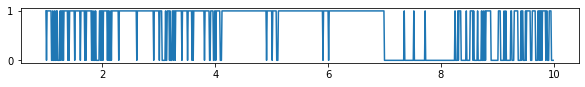

In [591]:
plt.figure(figsize=(10,1))
plt.plot(plot_data_x, plot_data_y, '-')
plt.show()

#### Other stuffs

In [725]:
instruction = """Say yes only if the first two elements are the same."""
alpaca_prompt_template = f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
%s

### Input:
%s

### Response:
"""
alpaca_prompt = alpaca_prompt_template % (instruction, "[apple orange orange]")

input_ids = tokenizer(alpaca_prompt, return_tensors="pt").input_ids.to("cuda")
generated_ids = model.generate(
    input_ids, do_sample=True, 
    temperature=0.01, max_length=input_ids[0].shape[0]+30,
)
generated_tokens = tokenizer.decode(generated_ids[0])
generated_tokens.split("</s>")[0].strip(".\n").split("\n")[-1]

'Yes'

In [276]:
instruction = """Please answer yes only if the numeric value is between 3.00 and 5.00, otherwise no."""
alpaca_prompt_template = f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
%s

### Input:
%s

### Response:
"""
alpaca_prompt = alpaca_prompt_template % (instruction, "6.00 minus 3.60")

input_ids = tokenizer(alpaca_prompt, return_tensors="pt").input_ids.to("cuda")
generated_ids = model.generate(
    input_ids, do_sample=True, 
    temperature=0.1, max_length=input_ids[0].shape[0]+30,
)
generated_tokens = tokenizer.decode(generated_ids[0])
generated_tokens.split("</s>")[0].strip(".\n").split("\n")[-1]

'No'

In [251]:
# Task Candidate 1 - Number Games
# prompt = """Please add the first two numbers together, and subtract the thrid one.
# 1, 4, 2 => 3
# ###
# 13, 5, 8 => 10
# ###
# 8, 9, 7 => """

# Task Candidate 2 - Operator Games
# prompt = """op i is either adding 1 to i when i is even, or adding 2 to i when i is odd.
# ###
# op 18 = 19
# ###
# op 17 = 16
# ###
# op 7 = 6
# ###
# op 3 = 2
# ###
# op 8 = 9
# ###
# op 19 ="""

# Task Candidate 3 - Semantic Related Games
# prompt = """if the first two words are synonyms add the following two numbers, if the first two words are antonyms return the first number
# ###
# Light Dark 1 1 => 1
# ###
# Happy Joyful 6 2 => 8
# ###
# Fast Slow 2 8 => 2
# ###
# Beautiful Attractive 1 9 => 10
# ###
# Happy Sad 3 2 =>"""

# More number games with substructures.
# prompt = """True if the sum of the left pair of numbers is equal to the sum of the left pair of numbers otherwise False.
# (3, 5), (3, 7) = False
# ###
# (2, 7), (5, 4) = True
# ###
# (7, 3), (9, 1) = """

input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
generated_ids = model.generate(
    input_ids, do_sample=True, 
    temperature=0.01, max_length=input_ids[0].shape[0]+5,
)
predicted_tokens = tokenizer.decode(generated_ids[0])
int(predicted_tokens.strip("#\n").split()[-1])

NameError: name 'prompt' is not defined

In [ ]:
clauses = "( c == a ) or ( a == b )"
n_shots = 20

pred_labels = []
correct_labels = []

for _ in tqdm(range(0, 500)):
    demo_set = sample_demonstrations_for_clauses_forward(
        clauses,
        n_shots
    )
    test_example =  sample_demonstrations_for_clauses_forward(
        clauses,
        1
    )
    prompt = "The hidden rule involves conducting equality analyses over numbers.\n"
    for i in range(0, len(demo_set)):
        prompt += f"Input: {demo_set[i]['a']} {demo_set[i]['b']} {demo_set[i]['c']}\nOutput: {demo_set[i]['output']}\n"
    prompt += f"Input: {test_example[0]['a']} {test_example[0]['b']} {test_example[0]['c']}\nOutput:"
    correct_labels += [test_example[0]['output']]
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
    generated_ids = model.generate(
        input_ids, do_sample=True, 
        temperature=0.01, max_length=input_ids[0].shape[0],
    )
    generated_text = tokenizer.decode(generated_ids[0])
    if generated_text.strip().split()[-1] == "True":
        pred_labels += [True]
    elif generated_text.strip().split()[-1] == "False":
        pred_labels += [False]

In [ ]:
print(classification_report(correct_labels, pred_labels)) # k=5

In [ ]:
generated_ids

### gpt-neo-2.7B

In [ ]:
model = GPTNeoForCausalLM.from_pretrained(
    "EleutherAI/gpt-neo-2.7B",
    cache_dir=CACHE_DIR
)
tokenizer = GPT2Tokenizer.from_pretrained(
    "EleutherAI/gpt-neo-2.7B",
    cache_dir=CACHE_DIR
)

In [ ]:
sum(p.numel() for p in model.parameters())

In [ ]:
model.to("cuda")

In [4]:
!nvidia-smi

Mon Apr 10 15:41:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:E1:00.0 Off |                  Off |
| 42%   72C    P2   296W / 300W |  36656MiB / 49140MiB |     98%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### gpt-j-6B

In [ ]:
model = GPTJForCausalLM.from_pretrained(
    "EleutherAI/gpt-j-6B", revision="float16", 
    cache_dir=CACHE_DIR
)
tokenizer = AutoTokenizer.from_pretrained(
    "EleutherAI/gpt-j-6B",
    cache_dir=CACHE_DIR
)

In [ ]:
sum(p.numel() for p in model.parameters())

In [ ]:
model.to("cuda")

In [ ]:
!nvidia-smi

In [ ]:
clauses = "( c == a ) or ( a == b )"
n_shots = 10

pred_labels = []
correct_labels = []

for _ in tqdm(range(0, 500)):
    demo_set = sample_demonstrations_for_clauses_forward(
        clauses,
        n_shots
    )
    test_example =  sample_demonstrations_for_clauses_forward(
        clauses,
        1
    )
    prompt = "The hidden rule involves conducting equality analyses over numbers.\n"
    for i in range(0, len(demo_set)):
        prompt += f"Input: {demo_set[i]['a']} {demo_set[i]['b']} {demo_set[i]['c']}\nOutput: {demo_set[i]['output']}\n"
    prompt += f"Input: {test_example[0]['a']} {test_example[0]['b']} {test_example[0]['c']}\nOutput:"
    correct_labels += [test_example[0]['output']]
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
    generated_ids = model.generate(
        input_ids, do_sample=True, 
        temperature=0.01, max_length=input_ids[0].shape[0],
    )
    generated_text = tokenizer.decode(generated_ids[0])
    if generated_text.strip().split()[-1] == "True":
        pred_labels += [True]
    elif generated_text.strip().split()[-1] == "False":
        pred_labels += [False]

In [ ]:
print(classification_report(correct_labels, pred_labels)) # k=5

In [ ]:
print(classification_report(correct_labels, pred_labels)) # k=15

In [ ]:
print(classification_report(correct_labels, pred_labels)) # k=25

In [ ]:
print(classification_report(correct_labels, pred_labels)) # k=35

In [ ]:
print(prompt)

In [ ]:
correct_labels[-1]